# <center>HNF</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from itertools import cycle
from tqdm import trange

from utils.NF_base import *
from utils.utils_hyperbolic import *
from utils.distributions import sampleWrappedNormal

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Utils

In [3]:
import math

from typing import Any, Tuple, Optional
from torch import Tensor

## From https://colab.research.google.com/drive/1kSdmi2r6QMO7gI8YPqeiWoW2ayxcu1MY?usp=sharing#scrollTo=LFl3I-ycM0vJ

eps = 1e-7
max_clamp_norm = 40
max_norm = 85
ln_2: torch.Tensor = math.log(2)

radius = torch.Tensor([1.0]).to(device)


def expand_proj_dims(x: torch.Tensor) -> torch.Tensor:
    zeros = torch.zeros(x.shape[:-1] + torch.Size([1])).to(x.device).to(x.dtype)
    return torch.cat((zeros, x), dim=-1)

# We will use this clamping technique to ensure numerical stability of the Exp and Log maps
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor, min: float, max: float) -> torch.Tensor:
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx: Any, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None, None]:
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * eps, None, None

def clamp(x: torch.Tensor, min: float = float("-inf"), max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)

def cosh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.cosh(x)

def sinh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.sinh(x)

# Exp map for the origin has a special form which doesn't need the Lorentz norm
def exp_map_mu0(x: Tensor, radius: Tensor) -> Tensor:
    assert x[..., 0].allclose(torch.zeros_like(x[..., 0]))
    x = x[..., 1:]
    x_norm = torch.norm(x, p=2, keepdim=True, dim=-1) / radius
    x_normed = F.normalize(x, p=2, dim=-1) * radius
    ret = torch.cat((cosh(x_norm) * radius, sinh(x_norm) * x_normed), dim=-1)
    assert torch.isfinite(ret).all()
    return ret

# Helper function to do the plotting
def plot_density(xy_poincare, probs, radius, mu=None, ax=None):
    axis_lim = 1
    
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)

    x = xy_poincare[:, 0].view(-1, 100).detach().cpu()
    y = xy_poincare[:, 1].view(-1, 100).detach().cpu()
    z = probs.view(-1, 100).detach().cpu()
    range_lim = 2
    # Define points within circle
    if mu is not None:
        mu = mu.cpu().numpy()
        plt.plot(mu[:, 0], mu[:, 1], 'b+')

    ax.contourf(x, y, z, 100, antialiased=False, cmap='jet')
    ax.axis('off')

    # Makes the circle look like a circle
    ax.axis('equal')
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)

### NF

In [4]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Tangent Coupling**:
- First project onto the tangent space (using log)
- Then apply a coupling layer
- Project back on the manifold (using exp)

In [5]:
def logMap(x, y):
    alpha = -minkowski_ip(x, y)
    diff = (y-alpha*x)
    return torch.arccosh(alpha) * diff/torch.sqrt(alpha**2-1+1e-8)

def logMap_x0(y):
    alpha = y[..., 0:1]
    diff = torch.cat([y[..., 0:1]-alpha, y[..., 1:]], dim=-1)
    return torch.arccosh(alpha) * diff/torch.sqrt(alpha**2-1+1e-8)

In [6]:
## v1: keep 0

class exp_hyperbolic(BaseNormalizingFlow):
    """
        
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        x0 = torch.zeros((1,dim-1), device=device)
        self.x0 = F.pad(x0, (1,0), value=1)

    def forward(self, x):
        x = clamp(x, min=-max_clamp_norm, max=max_clamp_norm)
        z = expMap(x, self.x0)
        
        norm_x = minkowski_ip(x, x)**(1/2)
        log_det = (self.dim-1) * (torch.log(torch.sinh(norm_x)) - torch.log(norm_x))
        
        return z, log_det[:,0]

    def backward(self, z):
        z = clamp(z, min=-max_clamp_norm, max=max_clamp_norm)
        return logMap_x0(z) 
#         return logMap(self.x0, z)
    
    
class log_hyperbolic(BaseNormalizingFlow):
    """
        
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        x0 = torch.zeros((1,dim-1), device=device)
        self.x0 = F.pad(x0, (1,0), value=1)
        
    def forward(self, x):
        x = clamp(x, min=-max_clamp_norm, max=max_clamp_norm)

#         z = logMap(self.x0, x)
        z = logMap_x0(x)
            
        norm_z = minkowski_ip(z, z)**(1/2)
        log_det = (1-d) * (torch.log(torch.sinh(norm_z)) - torch.log(norm_z))

        return z, log_det[:,0]

    def backward(self, z):
        z = clamp(z, min=-max_clamp_norm, max=max_clamp_norm)

        return expMap(z, self.x0)


In [309]:
## v2: remove 0 for log and add it for exp

class exp_hyperbolic2(BaseNormalizingFlow):
    """
        
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        x0 = torch.zeros((1,dim-1), device=device)
        self.x0 = F.pad(x0, (1,0), value=1)

    def forward(self, x):
        x = F.pad(x, (1,0), value=0)
        
        x = clamp(x, min=-max_clamp_norm, max=max_clamp_norm)
        z = expMap(x, self.x0)
        
        norm_x = minkowski_ip(x, x)**(1/2)
        log_det = (self.dim-2) * (torch.log(torch.sinh(norm_x)) - torch.log(norm_x))
        
        return z, log_det[:,0]

    def backward(self, z):
        z = clamp(z, min=-max_clamp_norm, max=max_clamp_norm)
        return logMap_x0(z)[..., 1:]
#         return logMap(self.x0, z)
    
    
class log_hyperbolic2(BaseNormalizingFlow):
    """
        
    """

    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        x0 = torch.zeros((1,dim-1), device=device)
        self.x0 = F.pad(x0, (1,0), value=1)
        
    def forward(self, x):
        x = clamp(x, min=-max_clamp_norm, max=max_clamp_norm)

#         z = logMap(self.x0, x)
        z = logMap_x0(x)
            
#         norm_z = minkowski_ip(z, z)**(1/2)
        norm_z = torch.norm(z, dim=-1, keepdim=True)
    
        log_det = (2-self.dim) * torch.log(torch.sinh(norm_z)/norm_z)
        
        if torch.any(torch.isnan(log_det)):
#             print("WTF", torch.any(torch.isnan(torch.log(norm_z))), torch.any(torch.isnan(torch.log(torch.sinh(norm_z)))))
#             print("WTFF", torch.any(torch.isnan(log_det)))
#             print(torch.log(torch.sinh(norm_z)))
#             print(torch.log(norm_z))
#             print(torch.log(torch.sinh(norm_z)/norm_z))
            print(";;;", torch.any(norm_z==0))
            inds = (norm_z==0).nonzero(as_tuple=True)[0]
            print(inds)
            print(norm_z[inds])
            print(z[inds])
            
            
        return z[..., 1:], log_det[:,0]

    def backward(self, z):
        z = F.pad(z, (1,0), value=0)
        z = clamp(z, min=-max_clamp_norm, max=max_clamp_norm)
        return expMap(z, self.x0)


In [310]:
x0 = torch.tensor([1,0,0], device=device)
Sigma0 = torch.eye(2, device=device)

init_samples = sampleWrappedNormal(x0, Sigma0, 100)

In [311]:
-init_samples[:,0]**2+init_samples[:,1]**2+init_samples[:,2]**2

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -0.9999, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

In [312]:
def loss(h, log_det):
    n, d = h.shape
    normal = D.Normal(torch.zeros(d-1, device=device), torch.ones(d-1, device=device))
#     x0 = torch.zeros((1, d-1), device=device)
#     x0 = F.pad(x0, (1,0), value=1)
    
    h = clamp(h, min=-max_clamp_norm, max=max_clamp_norm)
#     v = logMap(x0, h)
    v = logMap_x0(h)[..., 1:]
        
#     print("???", h.shape, x0.shape, v.shape)
#     print(v)
        
    norm_v = torch.norm(v) ## euclidean norm in tangent space of x0
    log_prior = normal.log_prob(v) - (d-2) * torch.log(torch.sinh(norm_v)/norm_v)
    
    return -(log_prior.sum(1) + log_det).mean()

def log_likelihood(h, log_det):
    n, d = h.shape
    normal = D.Normal(torch.zeros(d-1, device=device), torch.ones(d-1, device=device))
#     x0 = torch.zeros((1, d-1), device=device)
#     x0 = F.pad(x0, (1,0), value=1)
    
    h = clamp(h, min=-max_clamp_norm, max=max_clamp_norm)
#     v = logMap(x0, h)
    v = logMap_x0(h)[..., 1:]
    
    norm_v = torch.norm(v) ## euclidean norm in tangent space of x0
    log_prior = normal.log_prob(v) - (d-2) * torch.log(torch.sinh(norm_v)/norm_v)
    
    return log_prior.sum(1)+log_det

In [313]:
class AffineCoupling(BaseNormalizingFlow):
    """
    	Affine Coupling layer

    	Refs:
        - Density estimation using RealNVP
    """

    def __init__(self, scaling, shifting, dim):
        super().__init__()
        self.scaling = scaling
        self.shifting = shifting
        self.k = dim//2

    def forward(self, x):
        x0, x1 = x[:,:self.k], x[:,self.k:]

        s = torch.tanh(self.scaling(x0))
        t = self.shifting(x0)
        
        if torch.any(torch.isnan(s)):
            print("?? s")
            print(torch.any(torch.isnan(x0)))
        if torch.any(torch.isnan(t)):
            print("?? t")
        
        z0 = x0
        z1 = torch.exp(s)*x1+t

        z = torch.cat([z0,z1], dim=1)
        return z, torch.sum(s, dim=1)


    def backward(self, z):
        z0, z1 = z[:,:self.k], z[:,self.k:]

        s = torch.tanh(self.scaling(z0))
        t = self.shifting(z0)
        x0 = z0
        x1 = torch.exp(-s)*(z1-t)
        
        x = torch.cat([x0,x1], dim=1)
        return x #, -torch.sum(s, dim=1)
    
    
class AffineCoupling2(BaseNormalizingFlow):
    """
    	Affine Coupling layer

    	Refs:
        - Density estimation using RealNVP
    """

    def __init__(self, scaling, shifting, dim):
        super().__init__()
        self.scaling = scaling
        self.shifting = shifting
        self.k = dim//2

    def forward(self, x):
        x0, x1 = x[:,:self.k], x[:,self.k:]

        s = self.scaling(x0)
        s_constrained = torch.sigmoid(s + 2) + 1e-3
        t = self.shifting(x0)
        z0 = x0
        z1 = s_constrained*x1+t
        
        if torch.any(torch.isnan(s)):
            print("?? s")
            print(torch.any(torch.isnan(x0)))
        if torch.any(torch.isnan(t)):
            print("?? t")

        z = torch.cat([z0,z1], dim=1)
        return z, torch.sum(torch.log(s_constrained), dim=1)


    def backward(self, z):
        z0, z1 = z[:,:self.k], z[:,self.k:]

        s = self.scaling(z0)
        s_constrained = torch.sigmoid(s + 2) + 1e-3
        t = self.shifting(z0)
        x0 = z0
        x1 = (z1-t)/s_constrained
        
        x = torch.cat([x0,x1], dim=1)
        return x #, -torch.sum(s, dim=1)


class NormalizingFlows(BaseNormalizingFlow):
    """
        Composition of flows
        
        Refs: 
        - https://github.com/karpathy/pytorch-normalizing-flows/blob/master/nflib/flows.py
    """
    def __init__(self, flows):
        """
    		Inputs:
    		- flows: list of BaseNormalizingFlows objects
    	"""
        super().__init__()
        self.flows = nn.ModuleList(flows)
        
    def forward(self, x):
        log_det = torch.zeros(x.shape[0], device=device)
        zs = [x]
        for flow in self.flows:
            x, log_det_i = flow(x)
            
#             print(flow.__class__.__name__, zs[-1].shape, x.shape)
            
            if torch.any(torch.isnan(x)):
                print(flow.__class__.__name__, torch.any(torch.isnan(x)))
#                 print(zs[-1])
                
                if flow.__class__.__name__ == "log_hyperbolic":
                    alpha = minkowski_ip(flow.x0, zs[-1])
                    print("??", torch.any(torch.sqrt(alpha**2-1)==0))
                    print(torch.min(alpha**2))
                    return
                
            if torch.any(torch.isnan(log_det_i)):
                print("!!", flow.__class__.__name__)
                
            
            log_det += log_det_i
            zs.append(x)
        return zs, log_det
    
    def backward(self, z):
        log_det = torch.zeros(z.shape[0], device=device)
        xs = [z]
        for flow in self.flows[::-1]:
            z = flow.backward(z)
#             log_det += log_det_i
            xs.append(z)
        return xs #, log_det
        

In [314]:
mu = torch.tensor([8, np.sqrt(63), 0], dtype=torch.float, device=device)
Sigma = torch.tensor([[1,1/2],[1/2,1]], dtype=torch.float, device=device)
X_target = sampleWrappedNormal(mu, Sigma, 10000)

train_dl = DataLoader(X_target, batch_size=500, shuffle=True)
dataiter = iter(cycle(train_dl))

In [317]:
dim = 3
d = dim-1

shiftings = [shifting(d//2,64,(d+1)//2,3) for k in range(5)]
scalings = [shifting(d//2,64,(d+1)//2,3) for k in range(5)]

# flows = []
# for i in range(5):
#     flows.append(log_hyperbolic(dim))
#     flows.append(AffineCoupling(scalings[i],shiftings[i],d))
# #     flows.append(Reverse(d))
#     flows.append(exp_hyperbolic(dim))

flows = []
for i in range(5):
    flows.append(log_hyperbolic2(dim))
    flows.append(AffineCoupling2(scalings[i], shiftings[i], d))
    flows.append(Reverse(d))
    flows.append(exp_hyperbolic2(dim))
    
model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126730


  0%|          | 0/2501 [00:00<?, ?it/s]

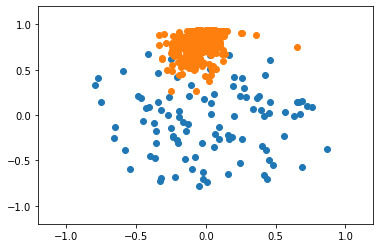

  2%|▏         | 49/2501 [00:03<02:37, 15.52it/s]

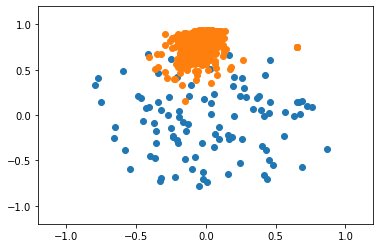

  4%|▍         | 99/2501 [00:06<02:31, 15.84it/s]

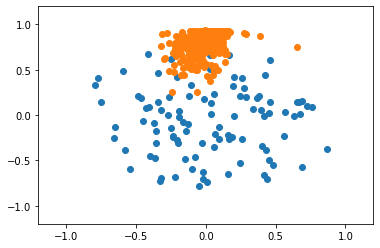

  6%|▌         | 149/2501 [00:10<02:36, 15.04it/s]

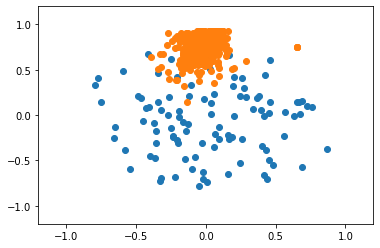

  8%|▊         | 199/2501 [00:13<02:23, 16.04it/s]

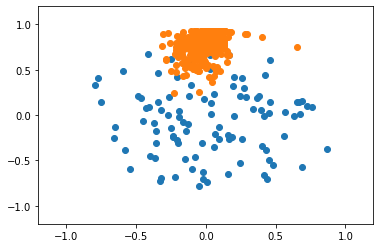

 10%|▉         | 249/2501 [00:16<02:25, 15.49it/s]

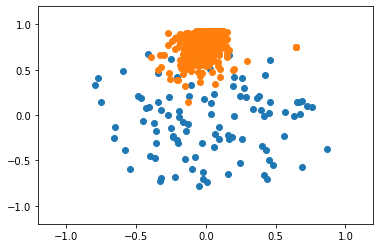

 12%|█▏        | 299/2501 [00:20<02:20, 15.71it/s]

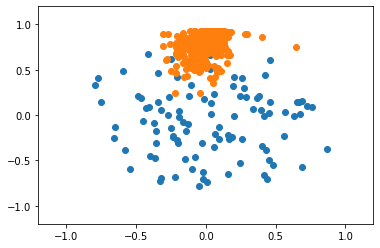

 14%|█▍        | 349/2501 [00:23<02:20, 15.27it/s]

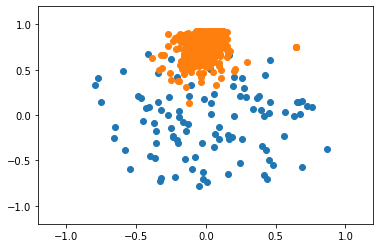

 16%|█▌        | 399/2501 [00:26<02:13, 15.73it/s]

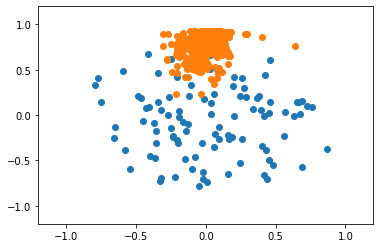

 18%|█▊        | 449/2501 [00:30<02:15, 15.11it/s]

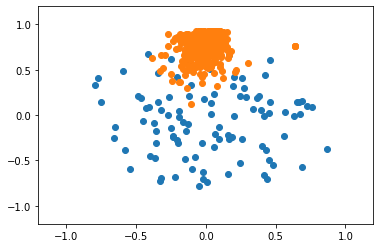

 20%|█▉        | 499/2501 [00:33<02:08, 15.56it/s]

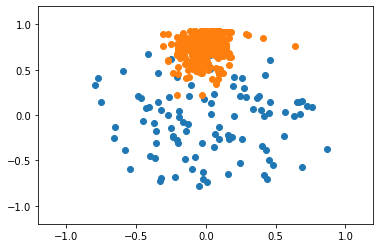

 22%|██▏       | 549/2501 [00:36<02:08, 15.22it/s]

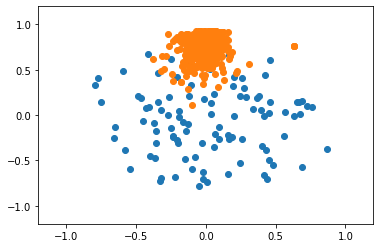

 24%|██▍       | 599/2501 [00:40<02:03, 15.38it/s]

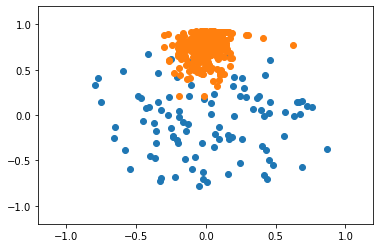

 26%|██▌       | 649/2501 [00:43<02:02, 15.11it/s]

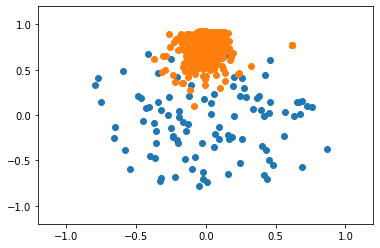

 28%|██▊       | 699/2501 [00:47<01:57, 15.35it/s]

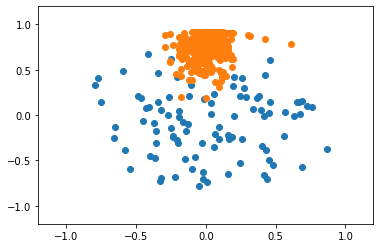

 30%|██▉       | 749/2501 [00:50<01:53, 15.44it/s]

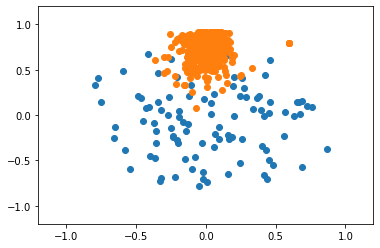

 32%|███▏      | 799/2501 [00:53<01:50, 15.39it/s]

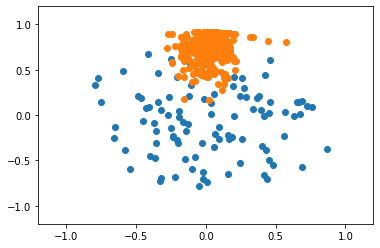

 34%|███▍      | 849/2501 [00:57<01:47, 15.41it/s]

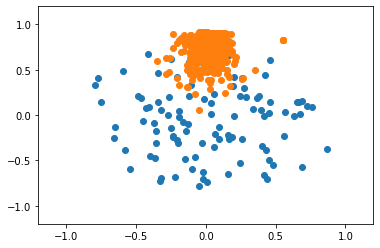

 36%|███▌      | 899/2501 [01:00<01:43, 15.50it/s]

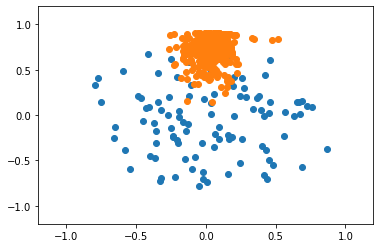

 38%|███▊      | 949/2501 [01:03<01:36, 16.14it/s]

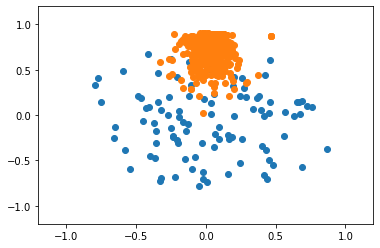

 40%|███▉      | 999/2501 [01:07<01:37, 15.36it/s]

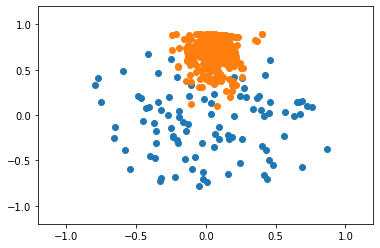

 42%|████▏     | 1049/2501 [01:10<01:35, 15.26it/s]

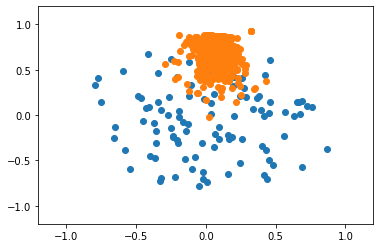

 44%|████▍     | 1099/2501 [01:13<01:32, 15.10it/s]

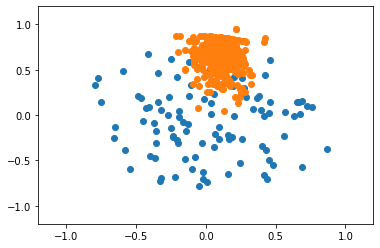

 46%|████▌     | 1149/2501 [01:17<01:26, 15.56it/s]

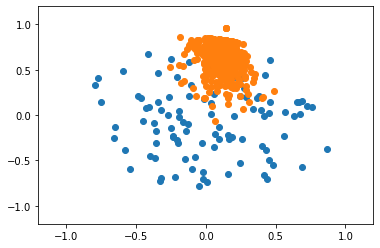

 48%|████▊     | 1199/2501 [01:20<01:24, 15.36it/s]

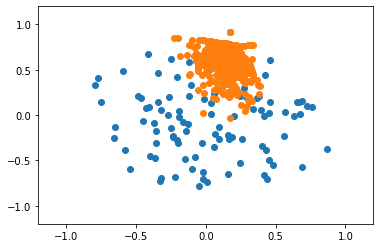

 50%|████▉     | 1249/2501 [01:23<01:19, 15.69it/s]

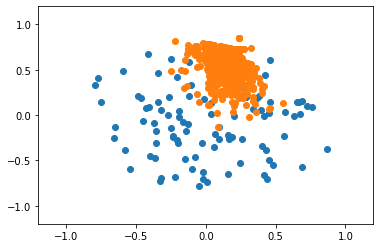

 52%|█████▏    | 1299/2501 [01:27<01:15, 15.95it/s]

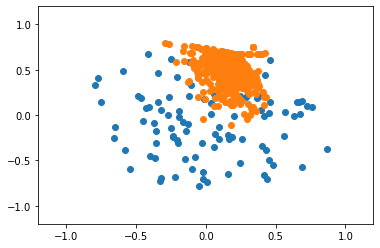

 54%|█████▍    | 1349/2501 [01:30<01:16, 15.12it/s]

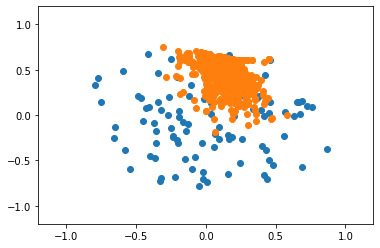

 56%|█████▌    | 1399/2501 [01:33<01:12, 15.30it/s]

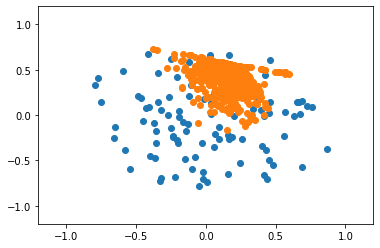

 58%|█████▊    | 1449/2501 [01:37<01:09, 15.21it/s]

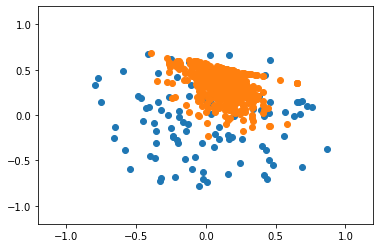

 60%|█████▉    | 1499/2501 [01:40<01:02, 16.08it/s]

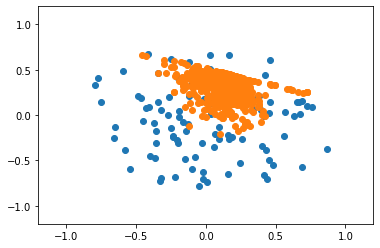

 62%|██████▏   | 1549/2501 [01:44<01:01, 15.39it/s]

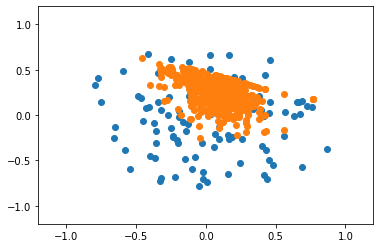

 64%|██████▍   | 1599/2501 [01:47<00:59, 15.26it/s]

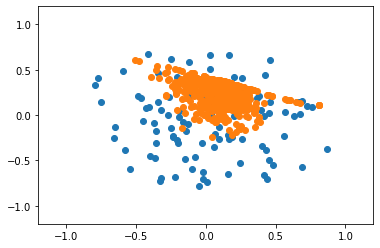

 66%|██████▌   | 1649/2501 [01:50<00:56, 15.14it/s]

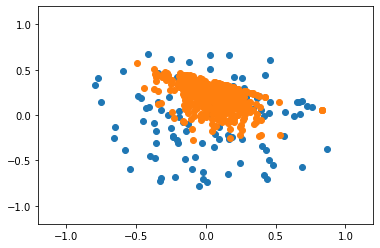

 68%|██████▊   | 1699/2501 [01:54<00:49, 16.06it/s]

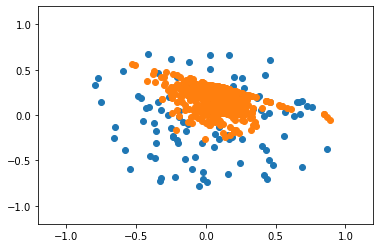

 70%|██████▉   | 1749/2501 [01:57<00:48, 15.40it/s]

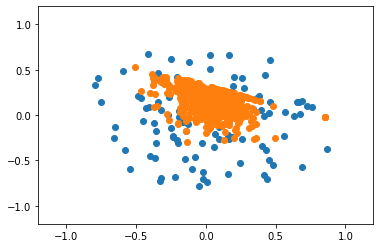

 72%|███████▏  | 1799/2501 [02:00<00:43, 16.04it/s]

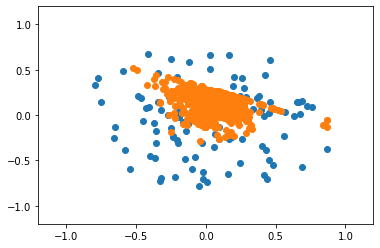

 74%|███████▍  | 1849/2501 [02:04<00:42, 15.23it/s]

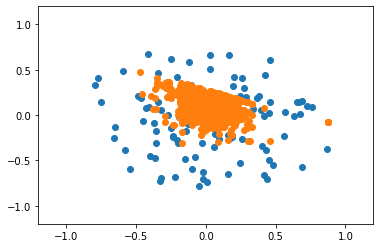

 76%|███████▌  | 1899/2501 [02:07<00:39, 15.12it/s]

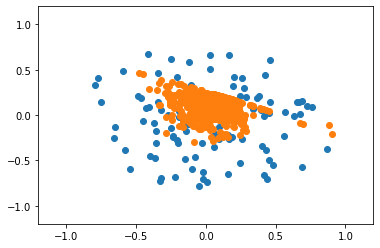

 78%|███████▊  | 1949/2501 [02:11<00:35, 15.63it/s]

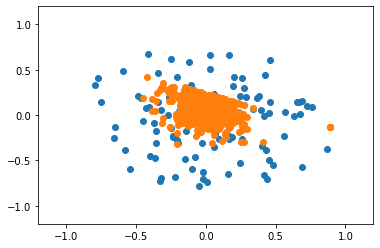

 80%|███████▉  | 1999/2501 [02:14<00:32, 15.28it/s]

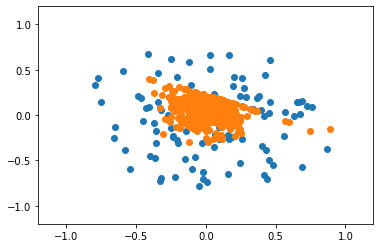

 82%|████████▏ | 2049/2501 [02:17<00:28, 15.94it/s]

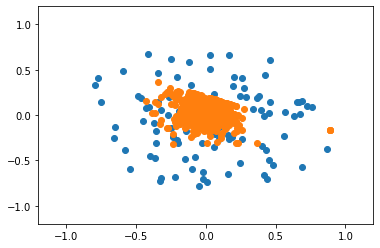

 84%|████████▍ | 2099/2501 [02:21<00:26, 15.25it/s]

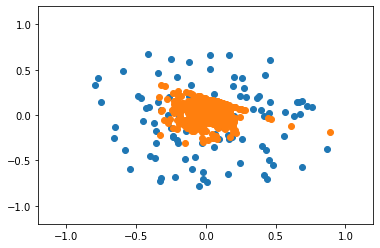

 86%|████████▌ | 2149/2501 [02:24<00:22, 15.48it/s]

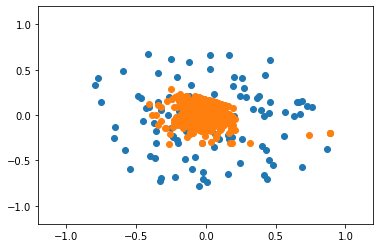

 88%|████████▊ | 2199/2501 [02:27<00:18, 16.48it/s]

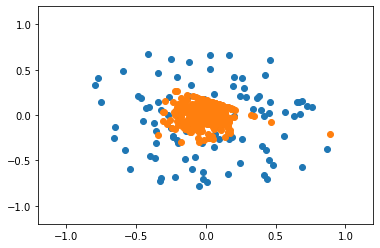

 90%|████████▉ | 2249/2501 [02:31<00:16, 15.38it/s]

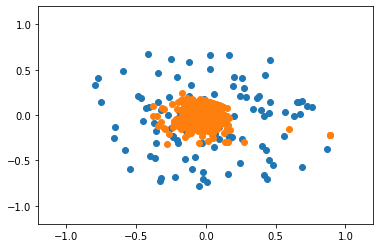

 92%|█████████▏| 2299/2501 [02:34<00:12, 16.06it/s]

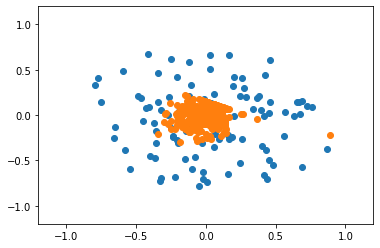

 94%|█████████▍| 2349/2501 [02:38<00:10, 14.95it/s]

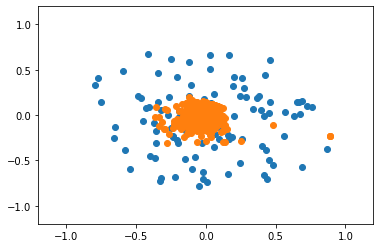

 96%|█████████▌| 2399/2501 [02:41<00:07, 14.45it/s]

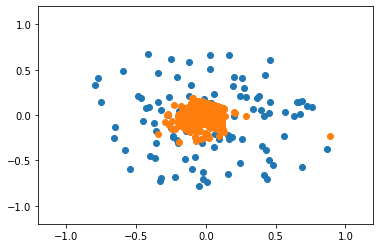

 98%|█████████▊| 2449/2501 [02:45<00:03, 14.46it/s]

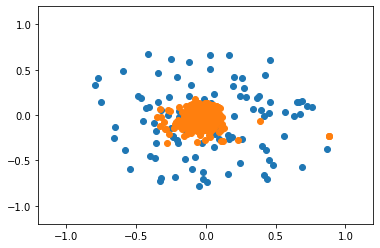

100%|█████████▉| 2499/2501 [02:48<00:00, 15.27it/s]

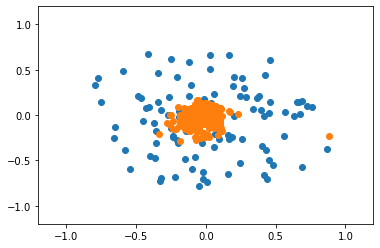

100%|██████████| 2501/2501 [02:49<00:00, 14.80it/s]


In [318]:
epochs = 2501

pbar = trange(epochs)
train_loss = []

for e in pbar:
    X_target = next(dataiter).type(torch.float).to(device)
    
    model.train()

    z, log_det = model(X_target)
#     print("??", z[-1])
    l = loss(z[-1], log_det)

    l.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss.append(l.item())
    
    
    if e%50 == 0:
        xx = lorentz_to_poincare(init_samples.cpu())
        yy = lorentz_to_poincare(z[-1].detach().cpu())

        plt.scatter(xx[:,0], xx[:,1])
        plt.scatter(yy[:,0], yy[:,1])
        plt.xlim(-1.2,1.2)
        plt.ylim(-1.2,1.2)
        plt.show()

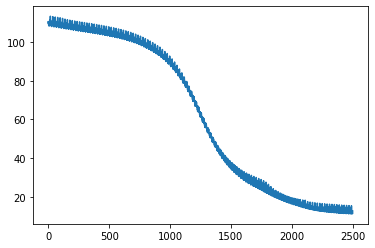

In [319]:
plt.plot(train_loss)
plt.show()

In [320]:
# Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
x, y = np.meshgrid(x, y)
x = torch.Tensor(x).view(-1, 1)
y = torch.Tensor(y).view(-1, 1)
twodim = torch.cat([x, y], dim=1)
threedim = expand_proj_dims(twodim)
clamped_threedim = clamp(threedim, min=-max_clamp_norm,
        max=max_clamp_norm).to(device)

on_mani = exp_map_mu0(clamped_threedim, radius)

In [321]:
z, log_det = model(on_mani)

;;; tensor(True, device='cuda:0')
tensor([5050], device='cuda:0')
tensor([[0.]], device='cuda:0')
tensor([[0., -0., -0.]], device='cuda:0')
!! log_hyperbolic2


In [324]:
logMap_x0(torch.tensor([1,0,0]))

tensor([0., 0., 0.])

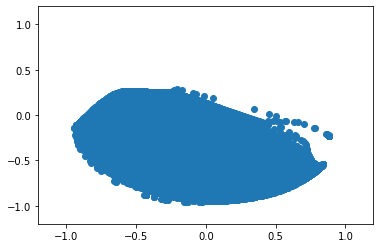

In [322]:
y = lorentz_to_poincare(z[-1]).detach().cpu()

plt.scatter(y[:,0], y[:,1])
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()

In [323]:
log_det.min()

tensor(nan, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
torch.any(torch.isnan(log_det))

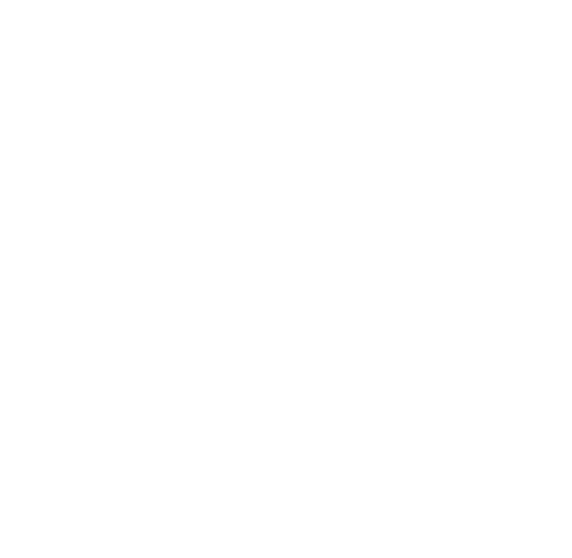

In [308]:
probs = log_likelihood(z[-1], log_det)#.exp().cpu() # torch.tensor(kernel.pdf(on_mani.T.detach().cpu().numpy()))

# Calculate the poincare coordinates
xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius)
# mu_p = lorentz_to_poincare(mu, radius)

plot_density(xy_poincare, probs, radius)

In [18]:
dim = 3
d = dim-1

shiftings = [shifting(d//2,64,(d+1)//2,3) for k in range(5)]
scalings = [shifting(d//2,64,(d+1)//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(log_hyperbolic(dim))
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
#     flows.append(Reverse(d))
    flows.append(exp_hyperbolic(dim))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126730


  0%|          | 0/1000 [00:00<?, ?it/s]

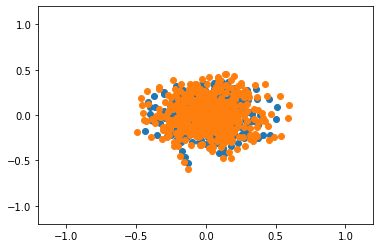

  0%|          | 1/1000 [00:00<03:21,  4.96it/s]

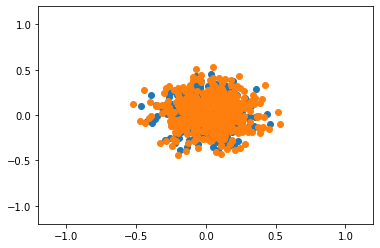

  0%|          | 2/1000 [00:00<03:17,  5.06it/s]

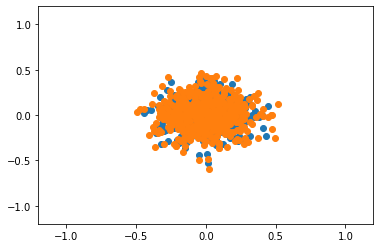

  0%|          | 3/1000 [00:00<03:15,  5.09it/s]

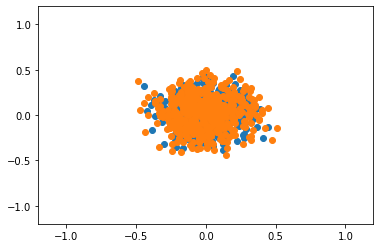

  0%|          | 4/1000 [00:00<03:16,  5.07it/s]

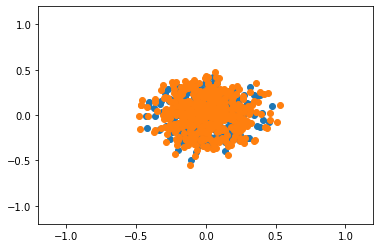

  0%|          | 5/1000 [00:00<03:16,  5.07it/s]

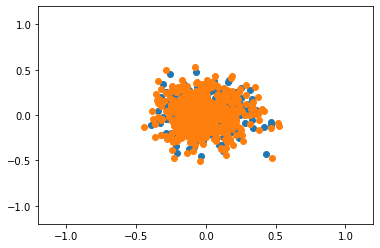

  1%|          | 6/1000 [00:01<03:16,  5.07it/s]

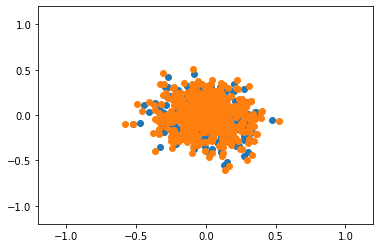

  1%|          | 7/1000 [00:01<03:14,  5.09it/s]

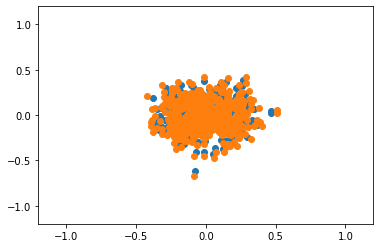

  1%|          | 8/1000 [00:01<03:14,  5.10it/s]

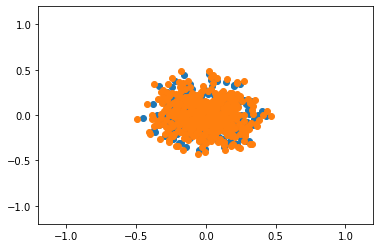

  1%|          | 9/1000 [00:01<03:14,  5.11it/s]

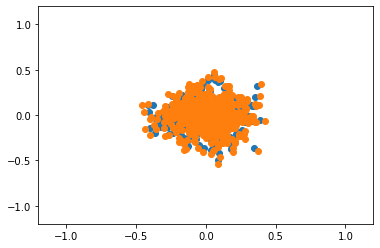

  1%|          | 10/1000 [00:01<03:13,  5.11it/s]

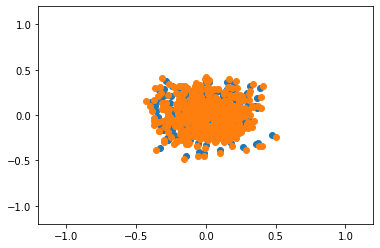

  1%|          | 11/1000 [00:02<03:13,  5.10it/s]

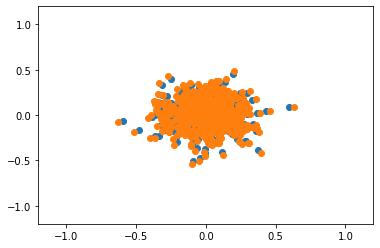

  1%|          | 12/1000 [00:02<03:13,  5.09it/s]

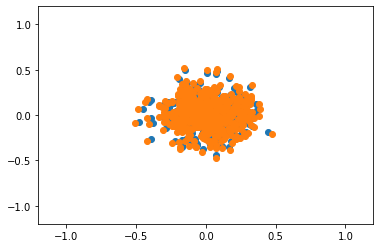

  1%|▏         | 13/1000 [00:02<03:30,  4.69it/s]

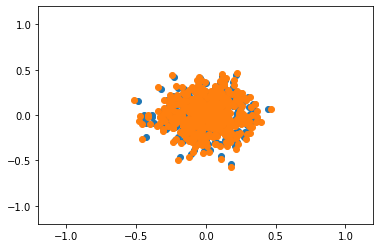

  1%|▏         | 14/1000 [00:02<03:25,  4.80it/s]

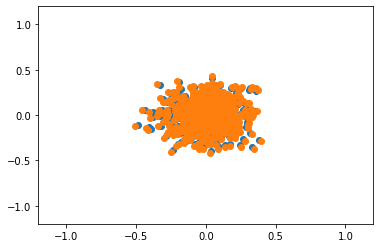

  2%|▏         | 15/1000 [00:03<03:21,  4.88it/s]

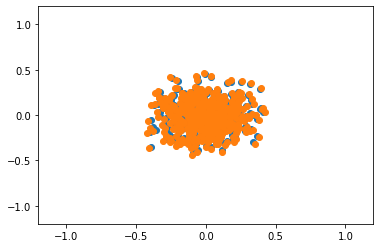

  2%|▏         | 16/1000 [00:03<03:19,  4.94it/s]

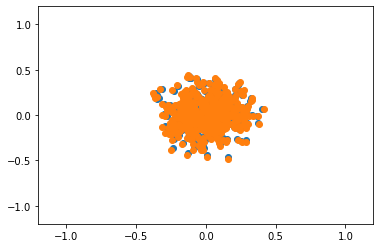

  2%|▏         | 17/1000 [00:03<03:15,  5.04it/s]

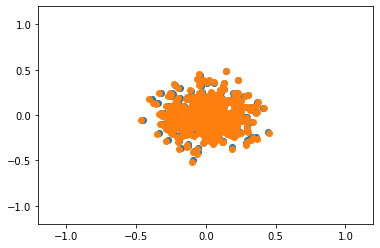

  2%|▏         | 18/1000 [00:03<03:12,  5.09it/s]

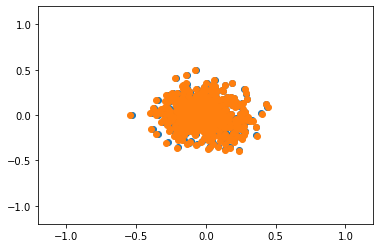

  2%|▏         | 19/1000 [00:03<03:13,  5.08it/s]

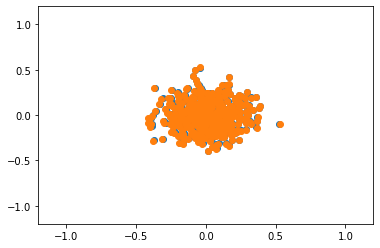

  2%|▏         | 20/1000 [00:03<03:14,  5.03it/s]

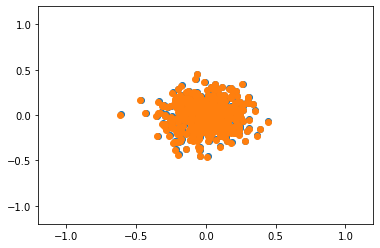

  2%|▏         | 21/1000 [00:04<03:12,  5.07it/s]

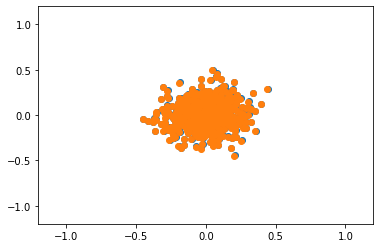

  2%|▏         | 22/1000 [00:04<03:12,  5.08it/s]

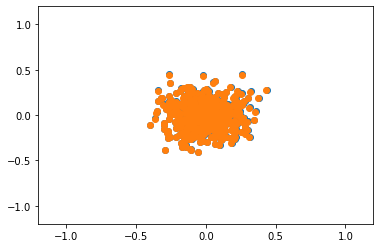

  2%|▏         | 23/1000 [00:04<03:12,  5.08it/s]

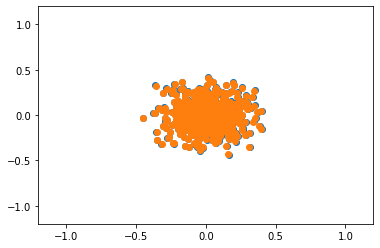

  2%|▏         | 24/1000 [00:04<03:12,  5.08it/s]

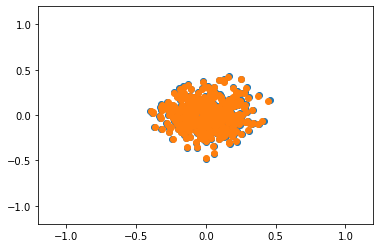

  2%|▎         | 25/1000 [00:04<03:11,  5.09it/s]

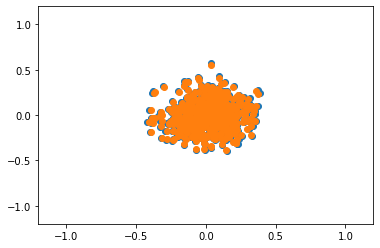

  3%|▎         | 26/1000 [00:05<03:26,  4.71it/s]

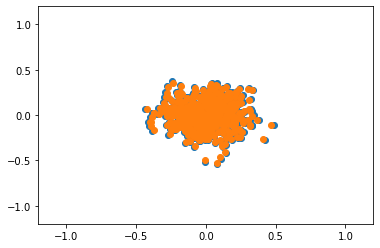

  3%|▎         | 27/1000 [00:05<03:21,  4.83it/s]

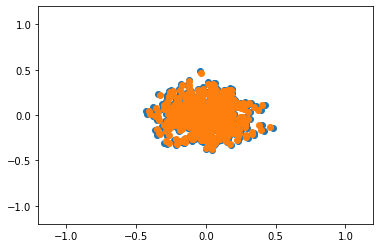

  3%|▎         | 28/1000 [00:05<03:19,  4.88it/s]

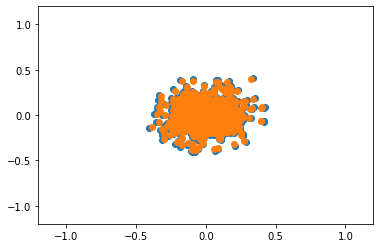

  3%|▎         | 29/1000 [00:05<03:17,  4.93it/s]

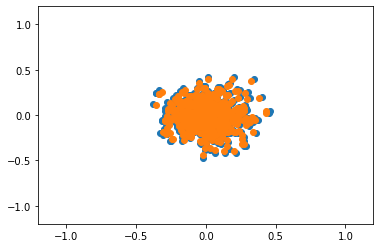

  3%|▎         | 30/1000 [00:05<03:14,  4.99it/s]

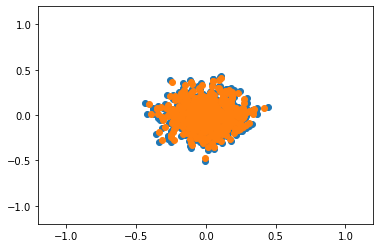

  3%|▎         | 31/1000 [00:06<03:13,  5.01it/s]

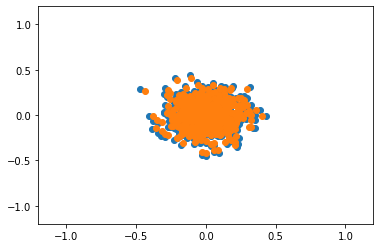

  3%|▎         | 32/1000 [00:06<03:12,  5.04it/s]

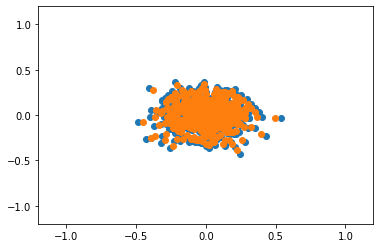

  3%|▎         | 33/1000 [00:06<03:11,  5.05it/s]

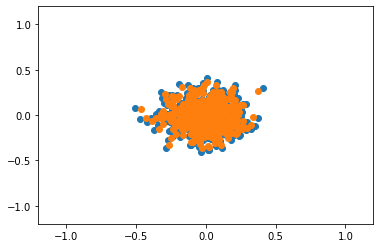

  3%|▎         | 34/1000 [00:06<03:10,  5.06it/s]

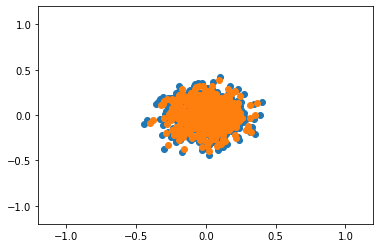

  4%|▎         | 35/1000 [00:06<03:08,  5.12it/s]

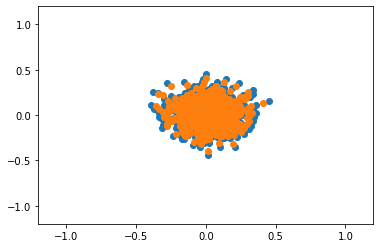

  4%|▎         | 36/1000 [00:07<03:09,  5.08it/s]

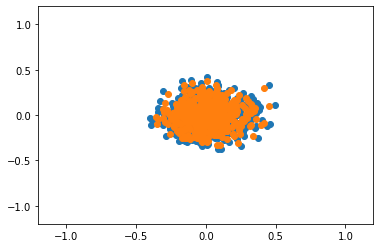

  4%|▎         | 37/1000 [00:07<03:08,  5.10it/s]

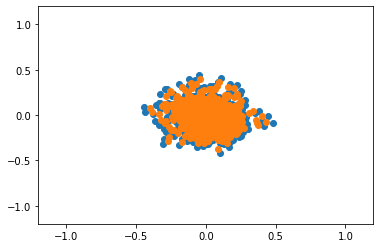

  4%|▍         | 38/1000 [00:07<03:08,  5.11it/s]

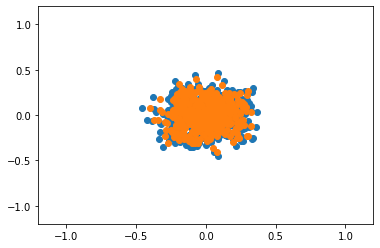

  4%|▍         | 39/1000 [00:07<03:22,  4.75it/s]

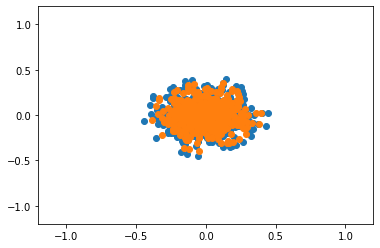

  4%|▍         | 40/1000 [00:08<03:18,  4.83it/s]

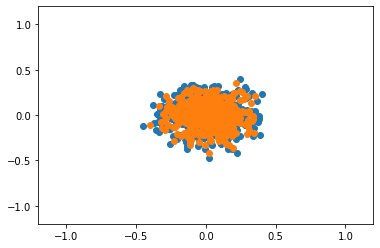

  4%|▍         | 41/1000 [00:08<03:15,  4.90it/s]

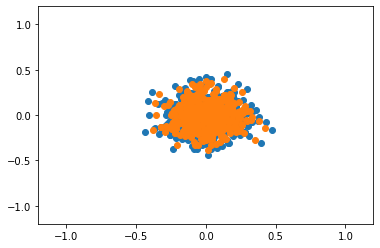

  4%|▍         | 42/1000 [00:08<03:13,  4.95it/s]

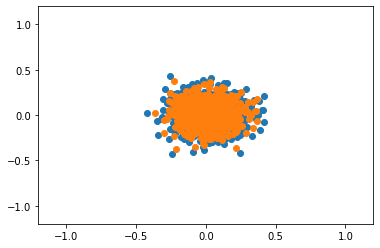

  4%|▍         | 43/1000 [00:08<03:09,  5.06it/s]

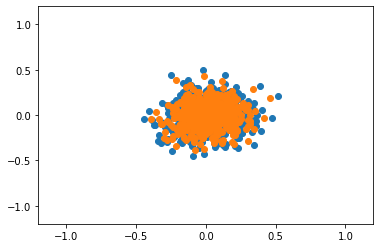

  4%|▍         | 44/1000 [00:08<03:08,  5.06it/s]

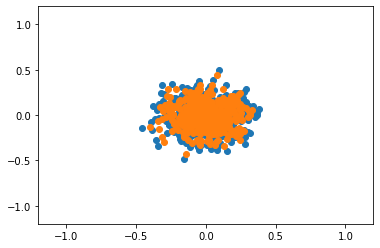

  4%|▍         | 45/1000 [00:08<03:05,  5.16it/s]

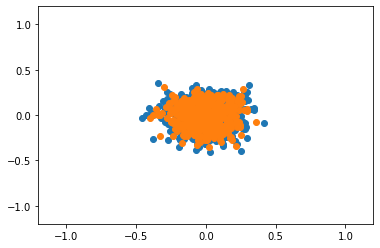

  5%|▍         | 46/1000 [00:09<03:06,  5.12it/s]

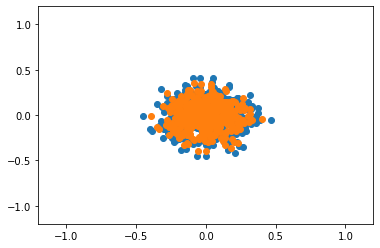

  5%|▍         | 47/1000 [00:09<03:05,  5.14it/s]

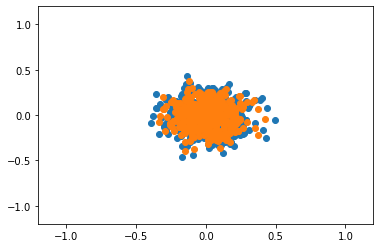

  5%|▍         | 48/1000 [00:09<03:04,  5.17it/s]

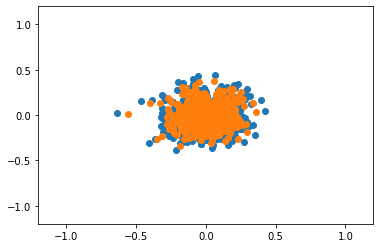

  5%|▍         | 49/1000 [00:09<03:05,  5.13it/s]

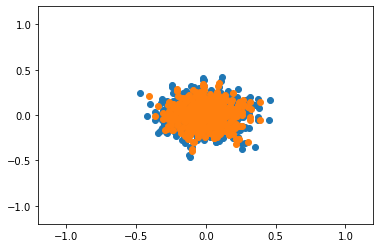

  5%|▌         | 50/1000 [00:09<03:05,  5.13it/s]

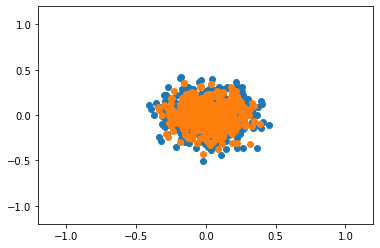

  5%|▌         | 51/1000 [00:10<03:05,  5.13it/s]

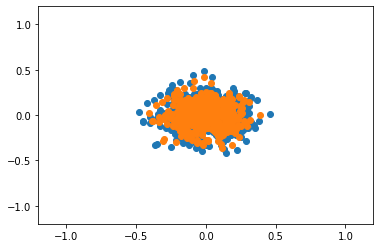

  5%|▌         | 52/1000 [00:10<03:20,  4.72it/s]

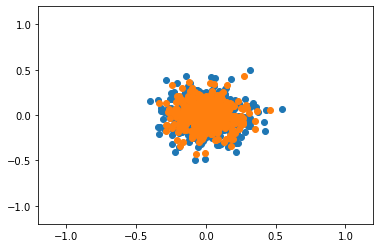

  5%|▌         | 53/1000 [00:10<03:16,  4.82it/s]

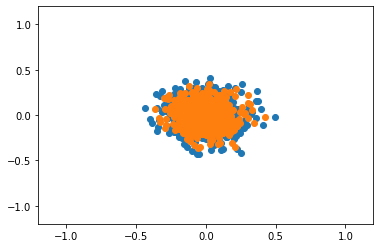

  5%|▌         | 54/1000 [00:10<03:12,  4.91it/s]

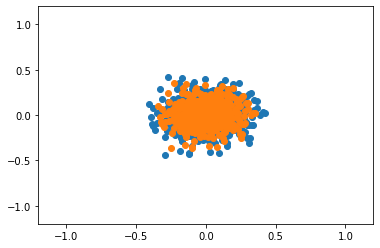

  6%|▌         | 55/1000 [00:10<03:10,  4.97it/s]

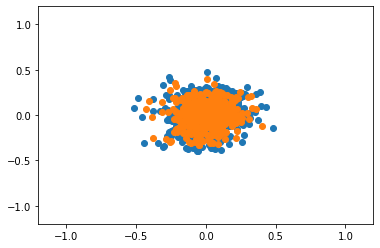

  6%|▌         | 56/1000 [00:11<03:08,  5.01it/s]

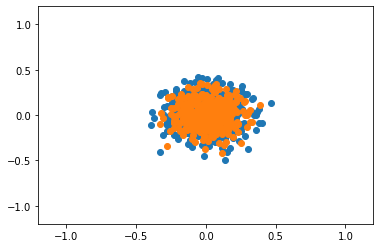

  6%|▌         | 57/1000 [00:11<03:07,  5.03it/s]

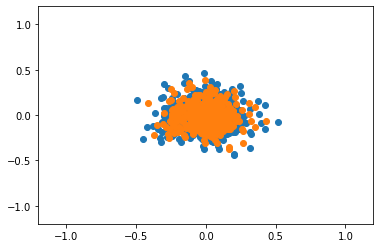

  6%|▌         | 58/1000 [00:11<03:07,  5.03it/s]

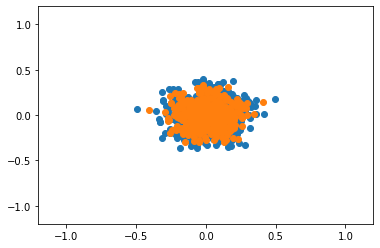

  6%|▌         | 59/1000 [00:11<03:05,  5.06it/s]

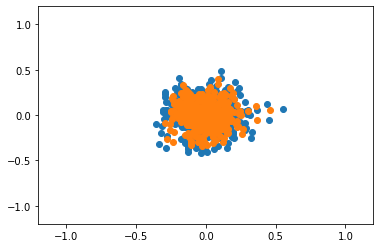

  6%|▌         | 60/1000 [00:11<03:05,  5.06it/s]

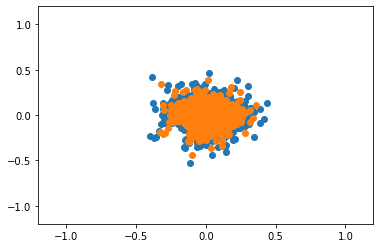

  6%|▌         | 61/1000 [00:12<03:03,  5.12it/s]

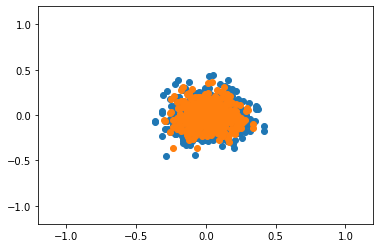

  6%|▌         | 62/1000 [00:12<03:02,  5.13it/s]

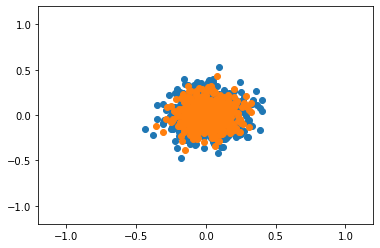

  6%|▋         | 63/1000 [00:12<03:01,  5.16it/s]

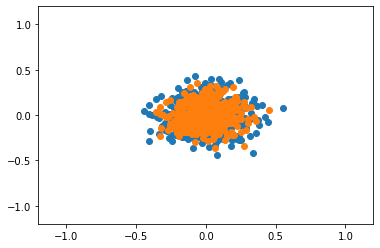

  6%|▋         | 64/1000 [00:12<03:00,  5.18it/s]

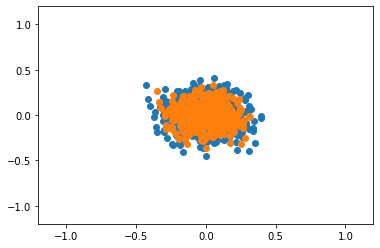

  6%|▋         | 65/1000 [00:12<03:16,  4.76it/s]

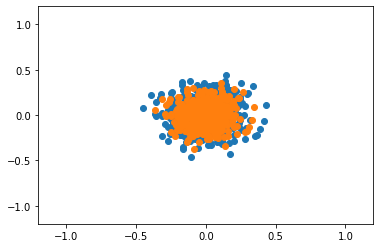

  7%|▋         | 66/1000 [00:13<03:11,  4.87it/s]

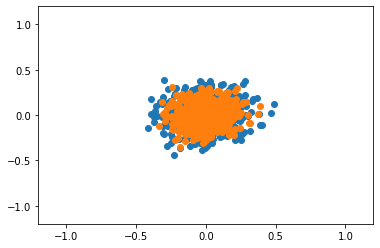

  7%|▋         | 67/1000 [00:13<03:09,  4.91it/s]

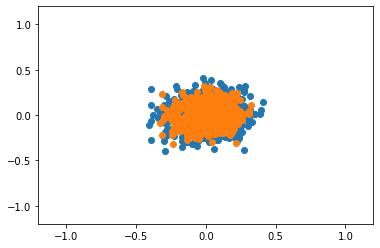

  7%|▋         | 68/1000 [00:13<03:08,  4.96it/s]

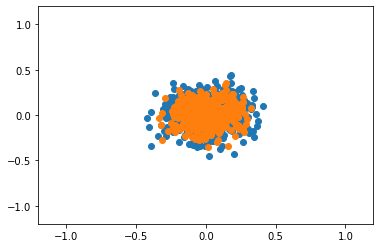

  7%|▋         | 69/1000 [00:13<03:06,  4.99it/s]

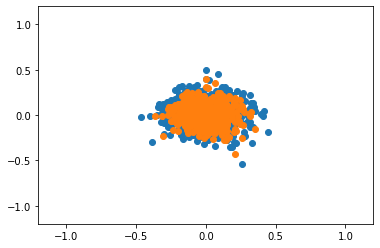

  7%|▋         | 70/1000 [00:13<03:05,  5.02it/s]

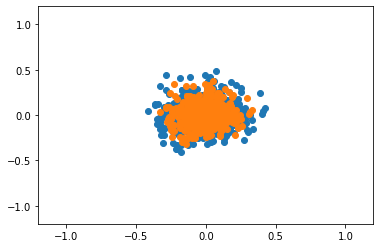

  7%|▋         | 71/1000 [00:14<03:04,  5.04it/s]

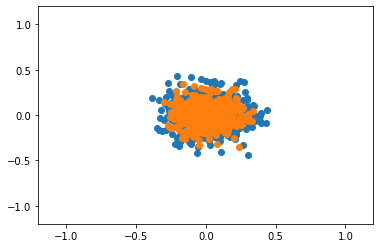

  7%|▋         | 72/1000 [00:14<03:03,  5.06it/s]

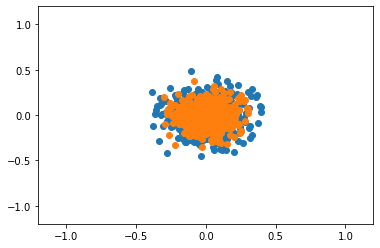

  7%|▋         | 73/1000 [00:14<03:03,  5.05it/s]

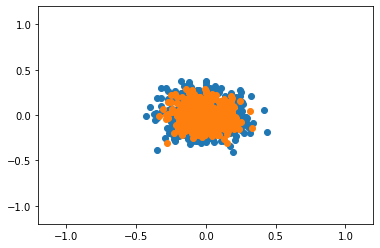

  7%|▋         | 74/1000 [00:14<03:02,  5.08it/s]

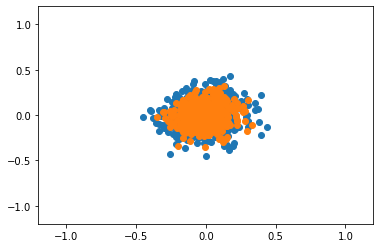

  8%|▊         | 75/1000 [00:14<03:01,  5.09it/s]

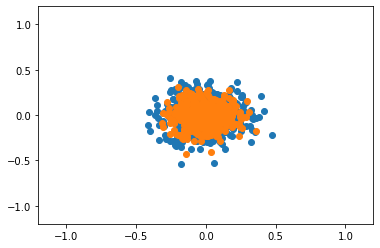

  8%|▊         | 76/1000 [00:15<03:01,  5.08it/s]

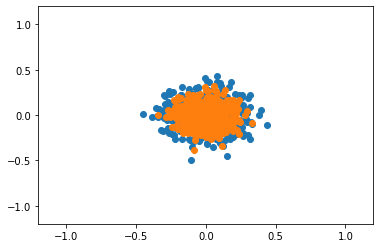

  8%|▊         | 77/1000 [00:15<03:01,  5.09it/s]

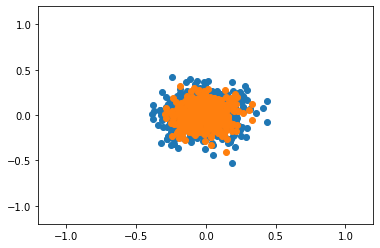

  8%|▊         | 78/1000 [00:15<03:15,  4.71it/s]

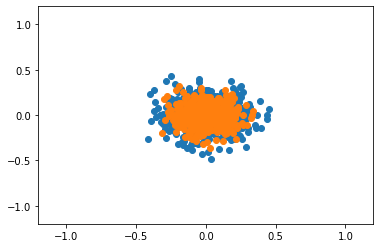

  8%|▊         | 79/1000 [00:15<03:10,  4.83it/s]

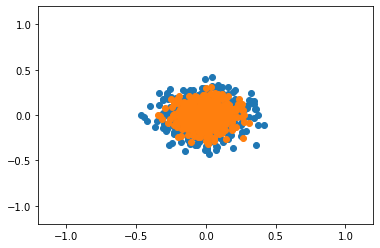

  8%|▊         | 80/1000 [00:15<03:07,  4.91it/s]

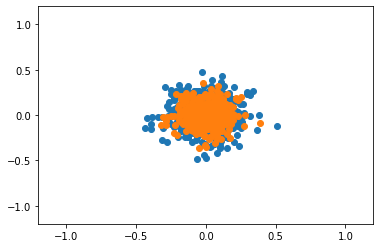

  8%|▊         | 81/1000 [00:16<03:04,  4.97it/s]

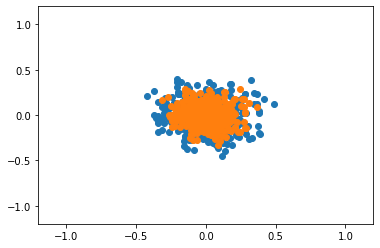

  8%|▊         | 82/1000 [00:16<03:02,  5.02it/s]

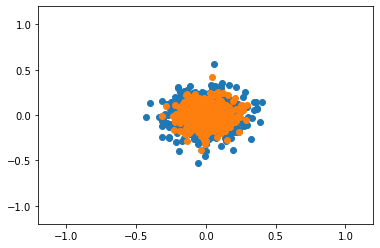

  8%|▊         | 83/1000 [00:16<03:02,  5.03it/s]

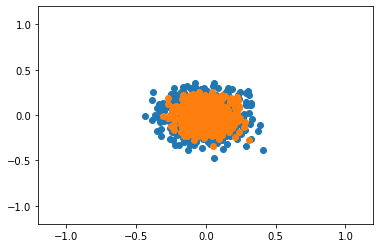

  8%|▊         | 84/1000 [00:16<03:01,  5.05it/s]

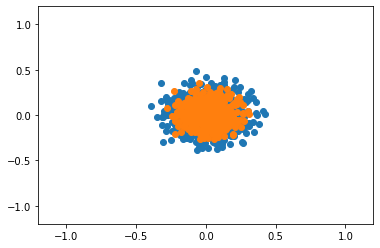

  8%|▊         | 85/1000 [00:16<03:00,  5.07it/s]

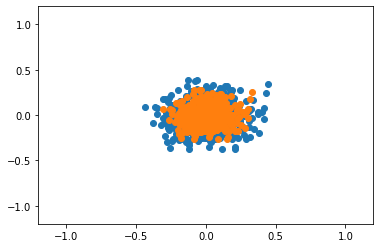

  9%|▊         | 86/1000 [00:17<03:00,  5.07it/s]

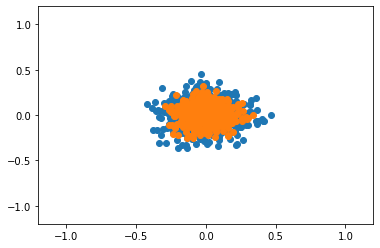

  9%|▊         | 87/1000 [00:17<02:59,  5.10it/s]

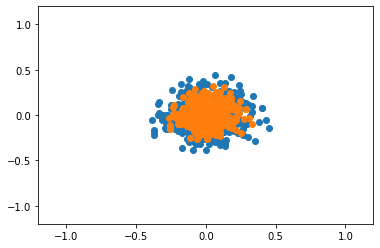

  9%|▉         | 88/1000 [00:17<02:58,  5.11it/s]

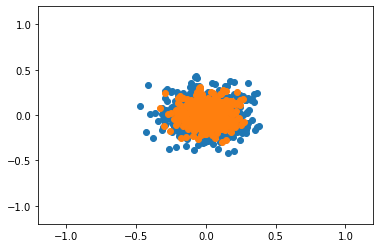

  9%|▉         | 89/1000 [00:17<02:59,  5.08it/s]

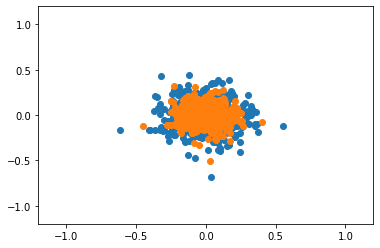

  9%|▉         | 90/1000 [00:17<02:58,  5.10it/s]

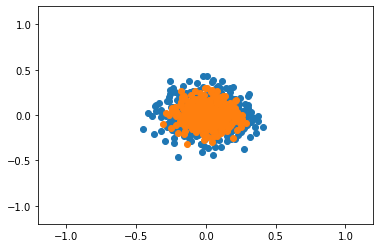

  9%|▉         | 91/1000 [00:18<03:14,  4.66it/s]

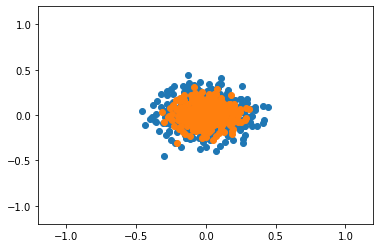

  9%|▉         | 92/1000 [00:18<03:09,  4.79it/s]

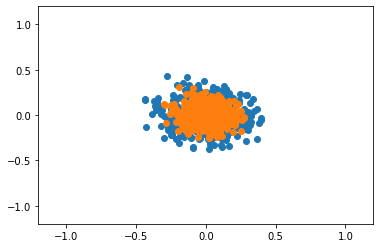

  9%|▉         | 93/1000 [00:18<03:05,  4.89it/s]

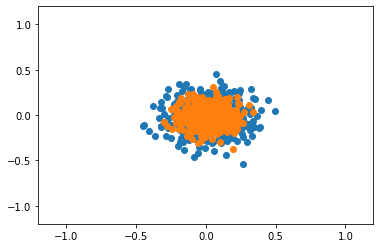

  9%|▉         | 94/1000 [00:18<03:02,  4.97it/s]

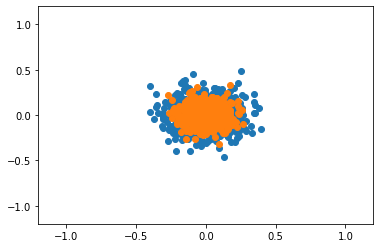

 10%|▉         | 95/1000 [00:18<02:59,  5.05it/s]

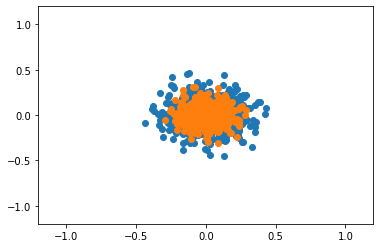

 10%|▉         | 96/1000 [00:19<02:59,  5.04it/s]

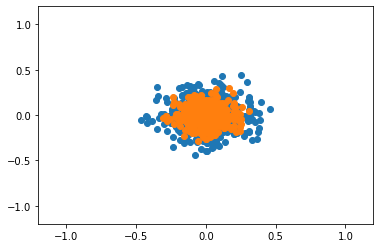

 10%|▉         | 97/1000 [00:19<02:58,  5.07it/s]

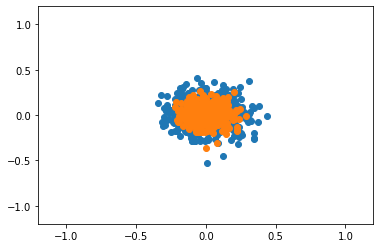

 10%|▉         | 98/1000 [00:19<02:57,  5.09it/s]

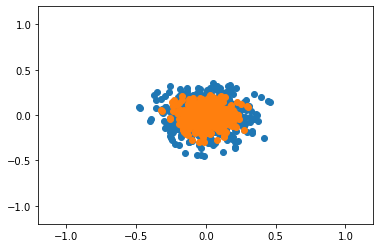

 10%|▉         | 99/1000 [00:19<02:58,  5.06it/s]

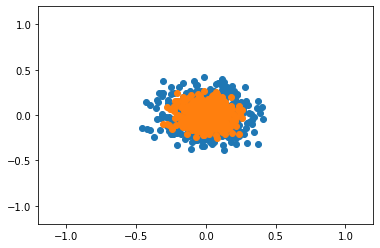

 10%|█         | 100/1000 [00:19<02:57,  5.07it/s]

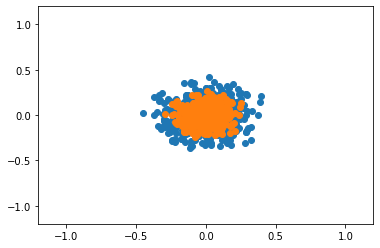

 10%|█         | 101/1000 [00:20<02:56,  5.09it/s]

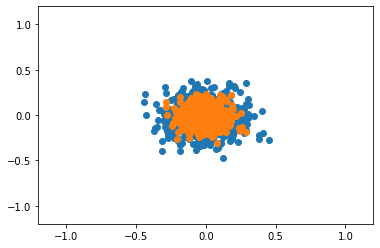

 10%|█         | 102/1000 [00:20<02:55,  5.11it/s]

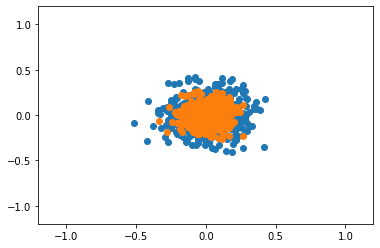

 10%|█         | 103/1000 [00:20<02:56,  5.08it/s]

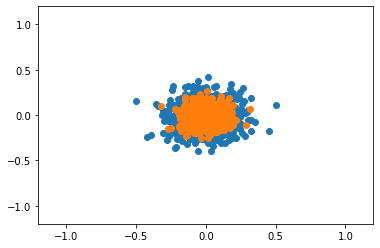

 10%|█         | 104/1000 [00:20<03:10,  4.71it/s]

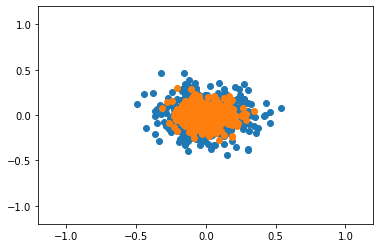

 10%|█         | 105/1000 [00:20<03:07,  4.77it/s]

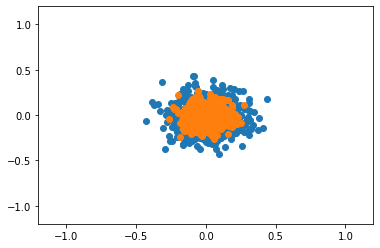

 11%|█         | 106/1000 [00:21<03:03,  4.88it/s]

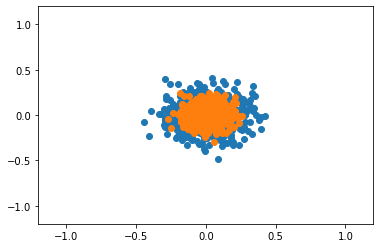

 11%|█         | 107/1000 [00:21<03:00,  4.96it/s]

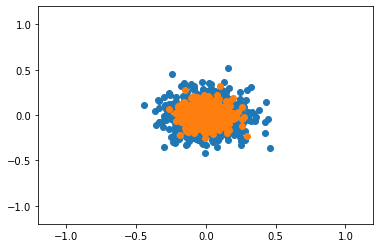

 11%|█         | 108/1000 [00:21<02:57,  5.02it/s]

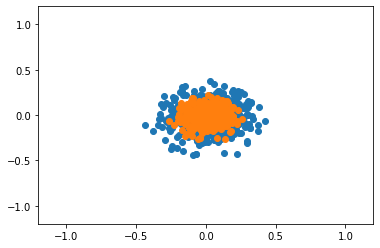

 11%|█         | 109/1000 [00:21<02:56,  5.05it/s]

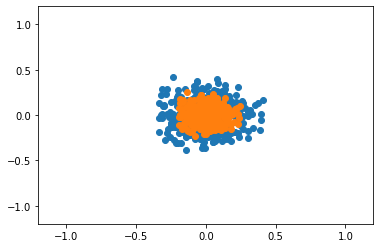

 11%|█         | 110/1000 [00:21<02:55,  5.06it/s]

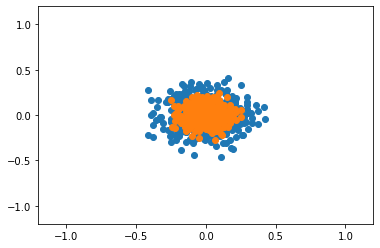

 11%|█         | 111/1000 [00:22<02:53,  5.13it/s]

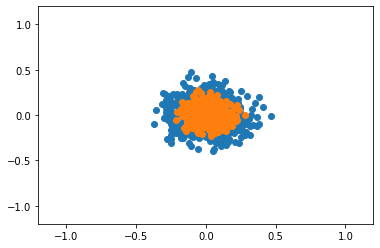

 11%|█         | 112/1000 [00:22<02:52,  5.14it/s]

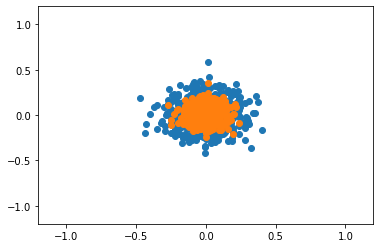

 11%|█▏        | 113/1000 [00:22<02:54,  5.09it/s]

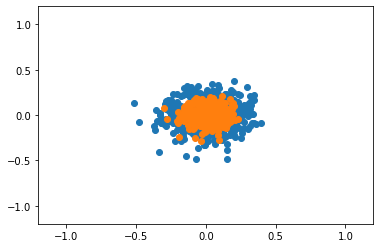

 11%|█▏        | 114/1000 [00:22<02:53,  5.11it/s]

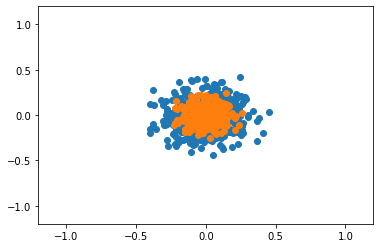

 12%|█▏        | 115/1000 [00:22<02:53,  5.10it/s]

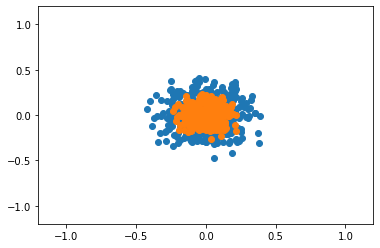

 12%|█▏        | 116/1000 [00:23<02:54,  5.08it/s]

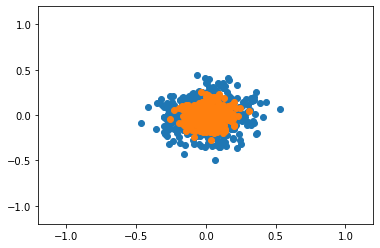

 12%|█▏        | 117/1000 [00:23<03:08,  4.69it/s]

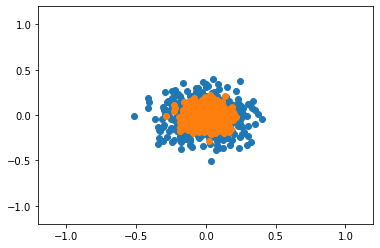

 12%|█▏        | 118/1000 [00:23<03:03,  4.80it/s]

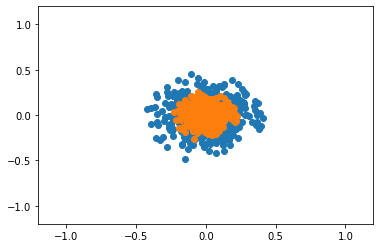

 12%|█▏        | 119/1000 [00:23<02:59,  4.90it/s]

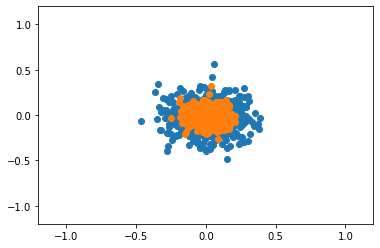

 12%|█▏        | 120/1000 [00:23<02:57,  4.97it/s]

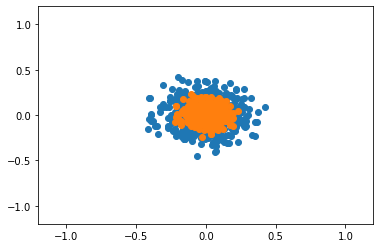

 12%|█▏        | 121/1000 [00:24<02:55,  5.00it/s]

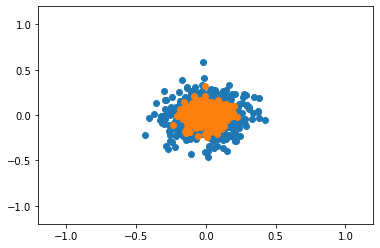

 12%|█▏        | 122/1000 [00:24<02:54,  5.04it/s]

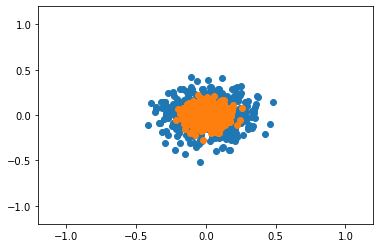

 12%|█▏        | 123/1000 [00:24<02:53,  5.06it/s]

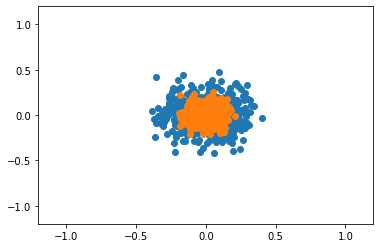

 12%|█▏        | 124/1000 [00:24<02:52,  5.06it/s]

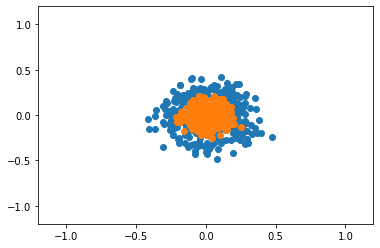

 12%|█▎        | 125/1000 [00:24<02:51,  5.11it/s]

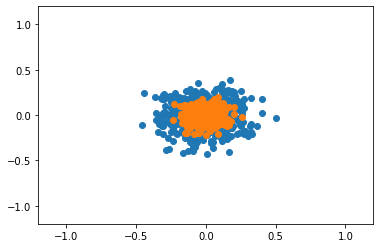

 13%|█▎        | 126/1000 [00:25<02:50,  5.12it/s]

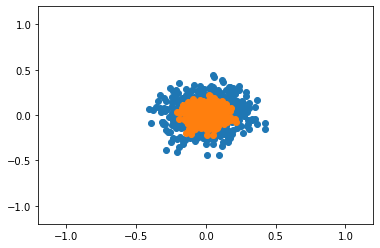

 13%|█▎        | 127/1000 [00:25<02:49,  5.14it/s]

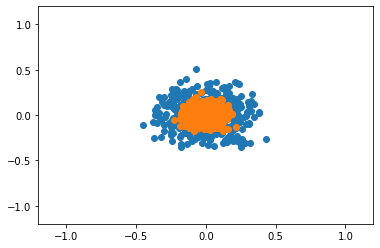

 13%|█▎        | 128/1000 [00:25<02:49,  5.14it/s]

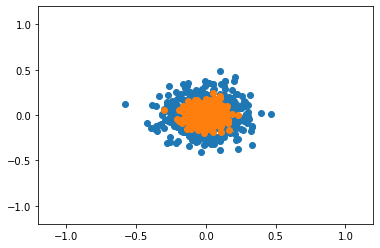

 13%|█▎        | 129/1000 [00:25<02:50,  5.12it/s]

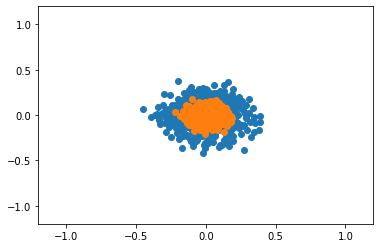

 13%|█▎        | 130/1000 [00:25<03:03,  4.74it/s]

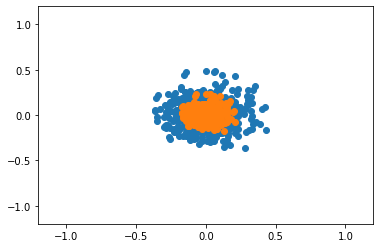

 13%|█▎        | 131/1000 [00:26<02:59,  4.83it/s]

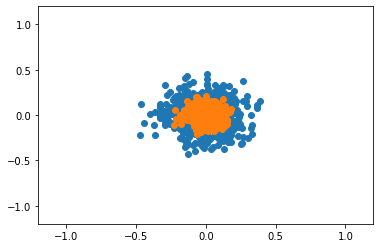

 13%|█▎        | 132/1000 [00:26<02:56,  4.93it/s]

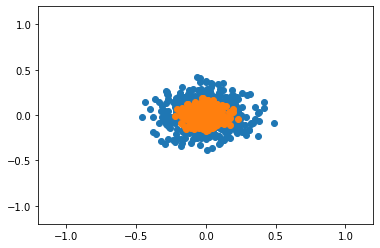

 13%|█▎        | 133/1000 [00:26<02:54,  4.97it/s]

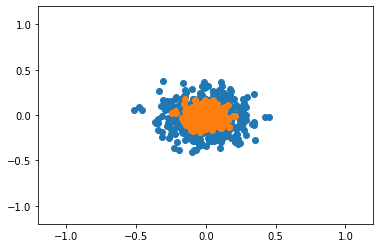

 13%|█▎        | 134/1000 [00:26<02:52,  5.02it/s]

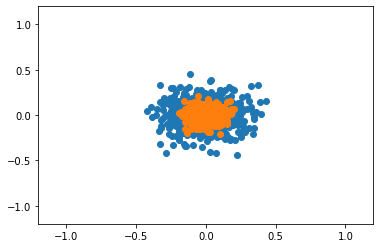

 14%|█▎        | 135/1000 [00:26<02:51,  5.05it/s]

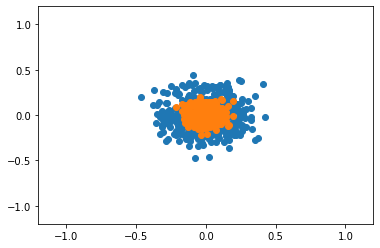

 14%|█▎        | 136/1000 [00:27<02:49,  5.09it/s]

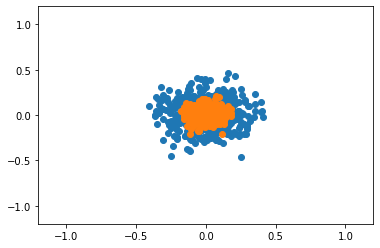

 14%|█▎        | 137/1000 [00:27<02:50,  5.06it/s]

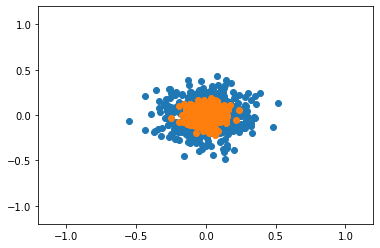

 14%|█▍        | 138/1000 [00:27<02:49,  5.09it/s]

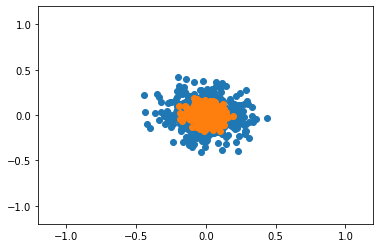

 14%|█▍        | 139/1000 [00:27<02:47,  5.14it/s]

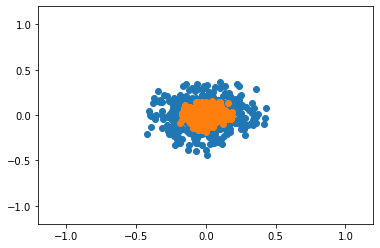

 14%|█▍        | 140/1000 [00:27<02:46,  5.15it/s]

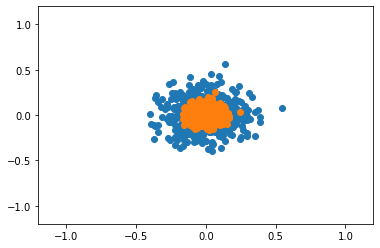

 14%|█▍        | 141/1000 [00:28<02:45,  5.19it/s]

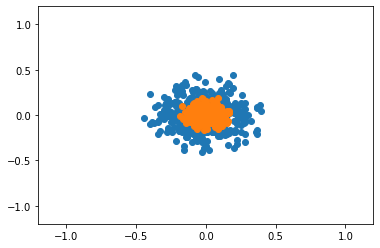

 14%|█▍        | 142/1000 [00:28<02:46,  5.16it/s]

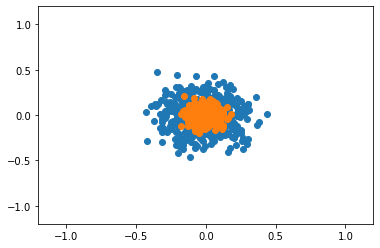

 14%|█▍        | 143/1000 [00:28<02:59,  4.78it/s]

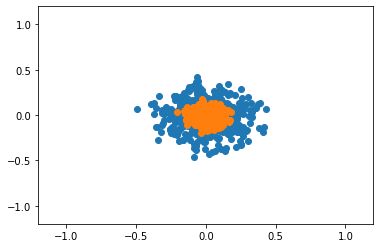

 14%|█▍        | 144/1000 [00:28<02:55,  4.89it/s]

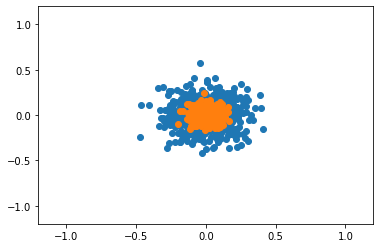

 14%|█▍        | 145/1000 [00:28<02:52,  4.96it/s]

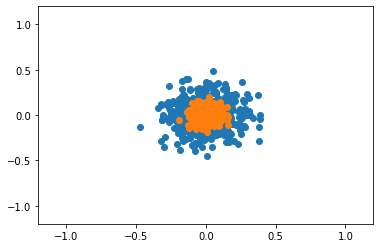

 15%|█▍        | 146/1000 [00:29<02:50,  5.02it/s]

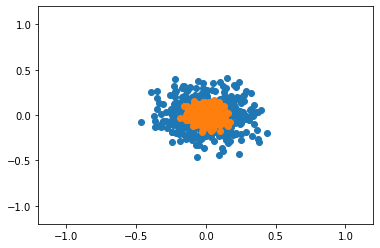

 15%|█▍        | 147/1000 [00:29<02:48,  5.05it/s]

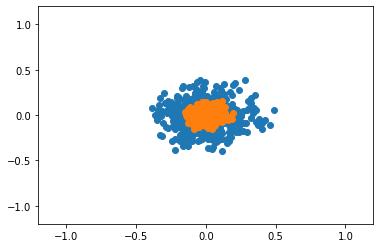

 15%|█▍        | 148/1000 [00:29<02:47,  5.09it/s]

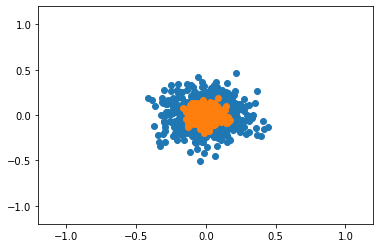

 15%|█▍        | 149/1000 [00:29<02:47,  5.08it/s]

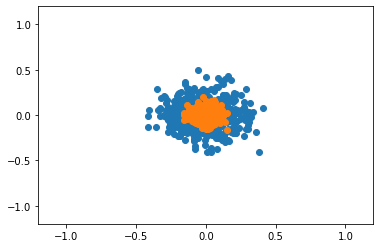

 15%|█▌        | 150/1000 [00:29<02:47,  5.09it/s]

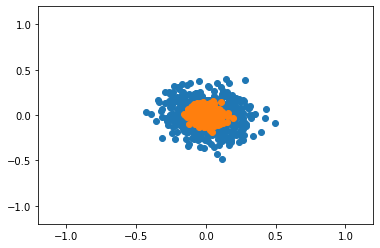

 15%|█▌        | 151/1000 [00:30<02:45,  5.12it/s]

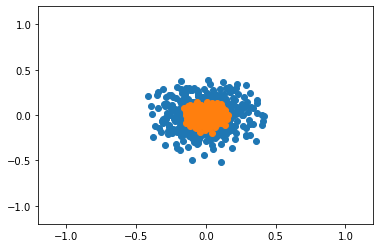

 15%|█▌        | 152/1000 [00:30<02:46,  5.11it/s]

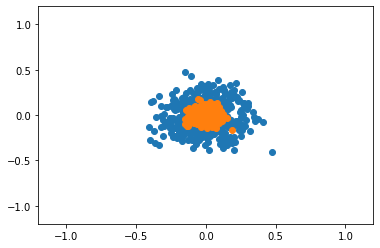

 15%|█▌        | 153/1000 [00:30<02:46,  5.09it/s]

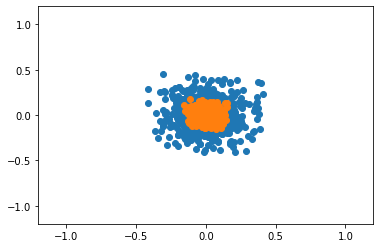

 15%|█▌        | 154/1000 [00:30<02:44,  5.13it/s]

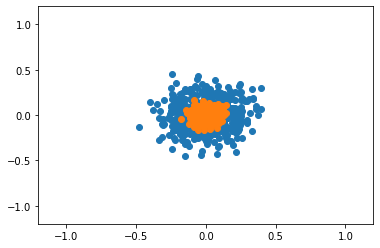

 16%|█▌        | 155/1000 [00:30<02:44,  5.15it/s]

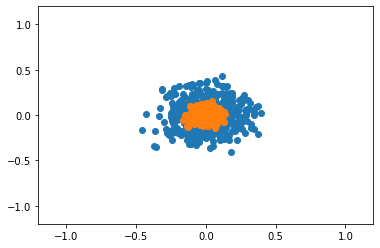

 16%|█▌        | 156/1000 [00:31<02:57,  4.75it/s]

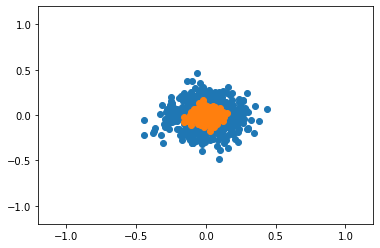

 16%|█▌        | 157/1000 [00:31<02:53,  4.85it/s]

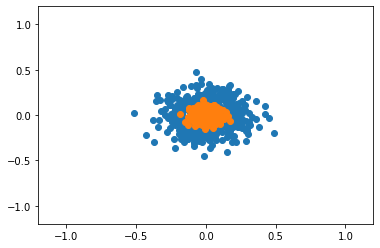

 16%|█▌        | 158/1000 [00:31<02:50,  4.93it/s]

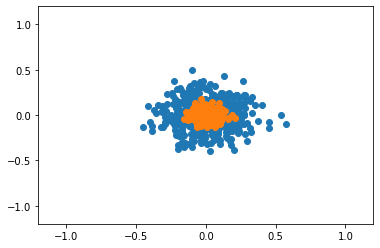

 16%|█▌        | 159/1000 [00:31<02:48,  4.99it/s]

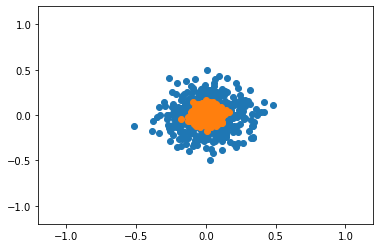

 16%|█▌        | 160/1000 [00:31<02:46,  5.04it/s]

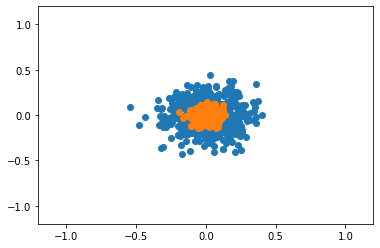

 16%|█▌        | 161/1000 [00:32<02:45,  5.06it/s]

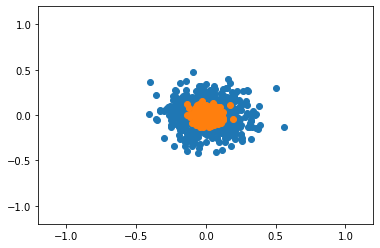

 16%|█▌        | 162/1000 [00:32<02:45,  5.08it/s]

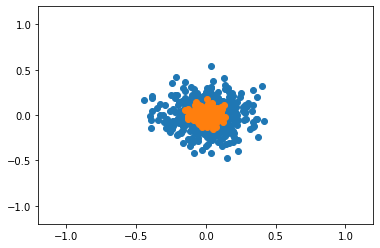

 16%|█▋        | 163/1000 [00:32<02:44,  5.10it/s]

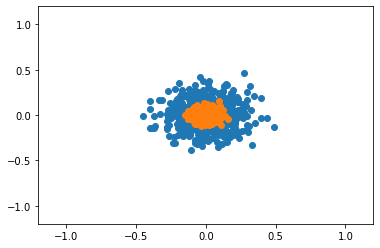

 16%|█▋        | 164/1000 [00:32<02:43,  5.11it/s]

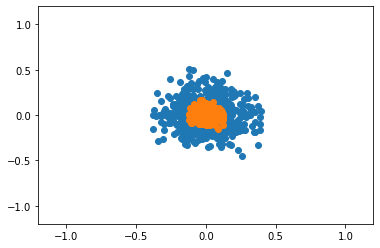

 16%|█▋        | 165/1000 [00:32<02:42,  5.13it/s]

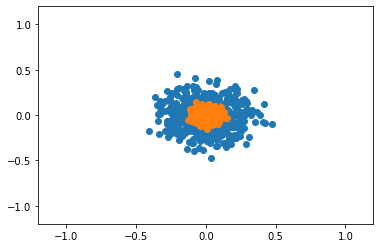

 17%|█▋        | 166/1000 [00:33<02:42,  5.13it/s]

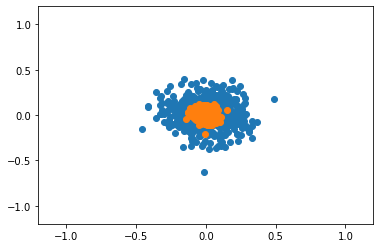

 17%|█▋        | 167/1000 [00:33<02:41,  5.15it/s]

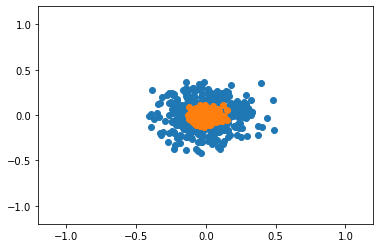

 17%|█▋        | 168/1000 [00:33<02:41,  5.17it/s]

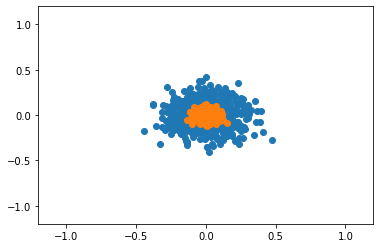

 17%|█▋        | 169/1000 [00:33<02:54,  4.76it/s]

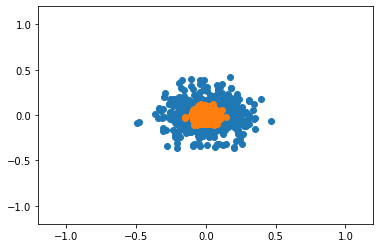

 17%|█▋        | 170/1000 [00:33<02:50,  4.87it/s]

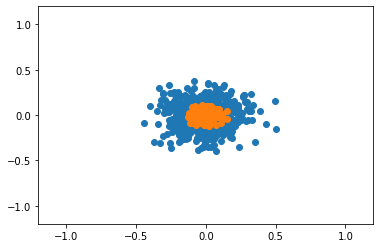

 17%|█▋        | 171/1000 [00:34<02:49,  4.90it/s]

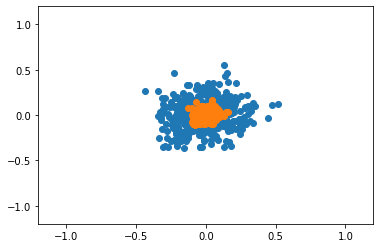

 17%|█▋        | 172/1000 [00:34<02:47,  4.95it/s]

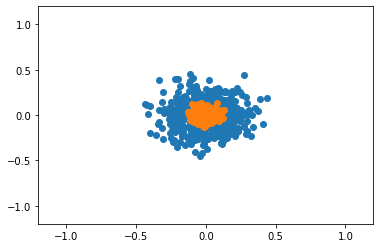

 17%|█▋        | 173/1000 [00:34<02:47,  4.93it/s]

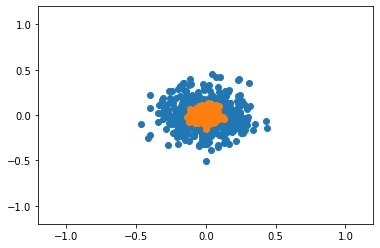

 17%|█▋        | 174/1000 [00:34<02:45,  4.99it/s]

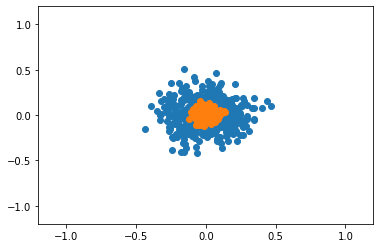

 18%|█▊        | 175/1000 [00:34<02:44,  5.02it/s]

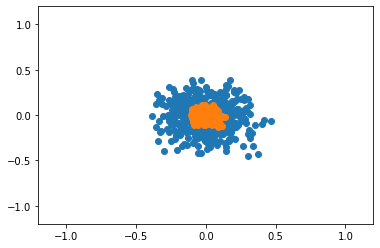

 18%|█▊        | 176/1000 [00:35<02:42,  5.06it/s]

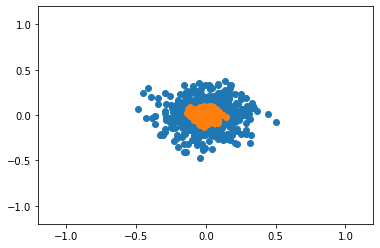

 18%|█▊        | 177/1000 [00:35<02:42,  5.07it/s]

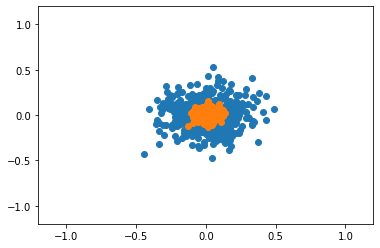

 18%|█▊        | 178/1000 [00:35<02:40,  5.12it/s]

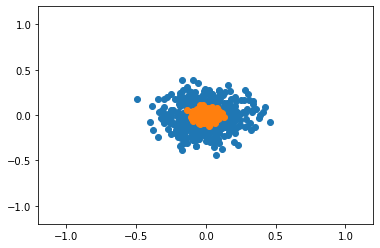

 18%|█▊        | 179/1000 [00:35<02:40,  5.11it/s]

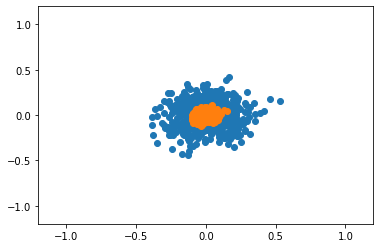

 18%|█▊        | 180/1000 [00:35<02:40,  5.12it/s]

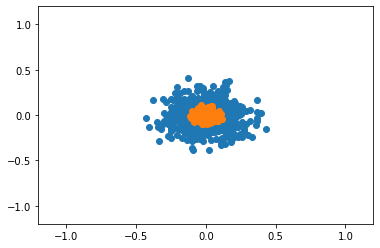

 18%|█▊        | 181/1000 [00:36<02:39,  5.13it/s]

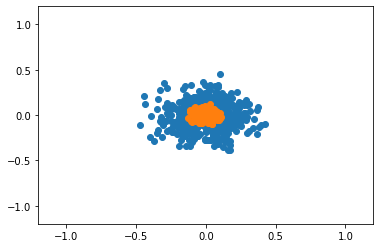

 18%|█▊        | 182/1000 [00:36<02:43,  5.01it/s]

?? s
tensor(False, device='cuda:0')
?? t
AffineCoupling tensor(True, device='cuda:0')
exp_hyperbolic tensor(True, device='cuda:0')
log_hyperbolic tensor(True, device='cuda:0')
?? tensor(False, device='cuda:0')
tensor(nan, device='cuda:0', grad_fn=<MinBackward1>)


TypeError: cannot unpack non-iterable NoneType object

In [19]:
bar = trange(1000)
for k in bar:
    init_samples = sampleWrappedNormal(x0, 0.1 * Sigma0, 500)
    
    z, log_det = model(init_samples)
    l = loss(z[-1], log_det)

    l.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss.append(l.item())
    
    xx = lorentz_to_poincare(init_samples.cpu())
    yy = lorentz_to_poincare(z[-1].detach().cpu())
    
    plt.scatter(xx[:,0], xx[:,1])
    plt.scatter(yy[:,0], yy[:,1])
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.show()

In [ ]:
xx = lorentz_to_poincare(init_samples.cpu())

plt.scatter(xx[:,0], xx[:,1])
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()